In [174]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [291]:
label=preprocessing.LabelEncoder()

In [357]:
import pandas as pd
import numpy as np
import random as rnd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics    
from sklearn import feature_selection
import mifs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize']=12,8

#len(data)
#data.head()


In [363]:
data=pd.read_excel("2010 Federal STEM Education Inventory Data Set.xls")


In [364]:
def columns(data):    
    column=pd.Series(data.loc['Index Number'].values)
    for j, i in column.iteritems():
        if pd.isna(i):
            column[j]=column[j-1]
            
    column[3:]=column[3:].map(lambda x: x.split(')')[1][1:])
    #column.head()    
    #data.columns    
    #data.loc['Index Number']=column.values
    data.columns=column.values
    data=data[1:-1]
    #data.columns.values 
    column_names=data.columns.values
    return data,column_names
#len(column_names)
data,column_names=columns(data)



In [36]:
#TestCase1
def test_columns():
    Data,Columns=columns(data)
    assert isinstance(data,pd.DataFrame)
    assert Data.shape==(252,255)
    assert Columns[0]=='Investment Name'
    assert isinstance(Columns[0],str)
    #assert Columns=list of columns names as desired
    

In [176]:
def describe_more( df ):
    var = [] ; l = [] ; t = [] ; numerical=[]; categorical=[]
    for n,x in enumerate(df):
        yup=pd.Series(df.iloc[:,n])        
        var.append( x )
        l.append( len( yup.value_counts() )) 
        t.append( yup.dtypes )
        if (len(yup[yup.notnull()]))>0:
            if isinstance(yup[yup.notnull()][0],numbers.Complex):  # this part of code changed after testing as Funding cols
                numerical.append(x)                                 # were getting left out due to dtype== object.
            else:
                categorical.append(x)
        else: categorical.append(x)
    #print(var,l,t)
    Info = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    Info.sort_values( by = 'Levels' , inplace = True )
    return Info, numerical,categorical,l

#Info,numerical,categorical,levels=describe_more(data)
#levels=describe_more(X)[3]
#len(levels)

In [177]:
#TestCase2
def test_describe_more():                               
    Info,numerical,categorical,levels=describe_more(data)
    assert isinstance(Info,pd.DataFrame)
    assert Info.shape==(255,3)
    assert isinstance(data[numerical[0]][0],numbers.Complex)     # Here I can check for every column of numerical or categorical
    assert not isinstance(data[categorical[0]][0],numbers.Complex) # by making a loop, but here I've not done it, as by choice data contains similar named columns
    assert isinstance(levels[0],int)                        # and for that it would be a long procedure to check how many columns are there under one name
                                         # But yes if the data has unique column names then a loop can be made to check for every..

In [231]:
def feature(data):
    unidentical_features=list(range(0,len(data)))
    identical_features=dict()
    stop=0
    for j,i in enumerate(column_names):
        if j<len(column_names)-1:
            if column_names[j]==column_names[j+1]:
                col=len(data.iloc[:,j].unique())
                try:
                    identical_features[stop].append([j,col])
                except:
                    start=j
                    stop=start
                    identical_features[start]=[[j,col]]
                if j==len(column_names)-2:
                    identical_features[stop].append([j+1,len(data.iloc[:,j+1].unique())])
                elif column_names[j]!=column_names[j+2]:
                    identical_features[stop].append([j+1,len(data.iloc[:,j+1].unique())])    
            else:
                stop=stop+1
    for key,val in identical_features.items():
        for i in val:
            if i[0] in unidentical_features:
                unidentical_features.remove(i[0])                
    return identical_features, unidentical_features

identical_features, unidentical_features=feature(data)

In [232]:
#TestCase3
def test_feature():                          # a loop can be put to test multiple time but random itself is appropriate
    identical_features, unidentical_features=feature(data)
    col_name=data.columns
    key=rnd.choice(list(identical_features.keys()))
    val=identical_features[key]
    identical_features.pop(key) # so random don't returns same 
    key1=rnd.choice(list(identical_features.keys()))
    val1=identical_features[key1]
    assert col_name[key]!=col_name[key1] 
    assert col_name[rnd.choice(val)[0]]==col_name[rnd.choice(val)[0]]
    assert col_name[rnd.choice(val1)[0]]==col_name[rnd.choice(val1)[0]]
    uni1=rnd.choice(unidentical_features)
    unidentical_features.remove(uni1)
    uni2=rnd.choice(unidentical_features)
    assert col_name[uni1]!=col_name[uni2]

In [6]:

def univariate_distribution(data):
    print("Non Funding Variables - two plots for each variable- First one count plot with y limit=no of samples for \
    getting idea of Nans")
    print("Second plot -label encoded ")
    plot_unidentical(unidentical_features)
    plot_identical(identical_features)
    print("Plotting histograms ALSO separately for numerical features like Year/ Joint Funding")
    plot_numeric()

#univariate_distribution(data)

def plot_numeric():
    data=pd.read_excel('output.xlsx')
    numerical=describe_more(data)[1]
    for i in numerical:
        t=data[i].dropna()
        fig,ax=plt.subplots()
        try:
            plt.hist(t)
            ax.set_xlabel(i)
            ax.set_ylabel('count')
            plt.show(ax)
        except:
            print('Cant be plotted')    
    
def plot_unidentical(feature):
    for i in unidentical_features:
        t=data.iloc[:,i]
        fig,ax=plt.subplots()
        sns.countplot(t,ax=ax)
        x=[0,50]
        y=[255,255]
        ax.plot(x,y)
        ax.set_xlabel(column_names[i])
        plt.show(ax)
        t=t.dropna()
        try:
            label.fit(t)
            uni_dist=label.transform(t)
            fig,ax=plt.subplots()
            sns.countplot(uni_dist,ax=ax)
            ax.set_xlabel(column_names[i])
            plt.show(ax)
        except:
            t=t.astype('category')
            fig,ax=plt.subplots()
            sns.countplot(t,ax=ax)
            ax.set_xlabel(column_names[i])
            plt.show(ax)
            
            
#plot_unidentical(unidentical_features)

def plot_identical(feature):
    for key in feature:    
        features=data[column_names[key]]
        features_col=features.columns.values
        for j,i in enumerate(features_col):
            features_col[j]=i+str(j)
        features.columns=features_col
        t=pd.Series()
        for j,i in enumerate(features):
            t=t.append(features[i])
        fig,ax=plt.subplots()
        sns.countplot(t,ax=ax)
        x=[0,50]
        y=[255,255]
        ax.plot(x,y)
        ax.set_xlabel(column_names[key])
        plt.show(ax)
        t=t.dropna()
        try:
            label.fit(t)
            uni_dist=label.transform(t)
            fig,ax=plt.subplots()
            sns.countplot(uni_dist,ax=ax)
            ax.set_xlabel(column_names[key])
            plt.show(ax)
        except:
            t=t.astype('category')
            fig,ax=plt.subplots()
            sns.countplot(uni_dist,ax=ax)
            ax.set_xlabel(column_names[key])
            plt.show(ax)

In [ ]:
#no test cases for plot functions as their return value is none but the graphs which needs visual testing

Non Funding Variables - two plots for each variable- First one count plot with y limit=no of samples for     getting idea of Nans
Second plot -label encoded 


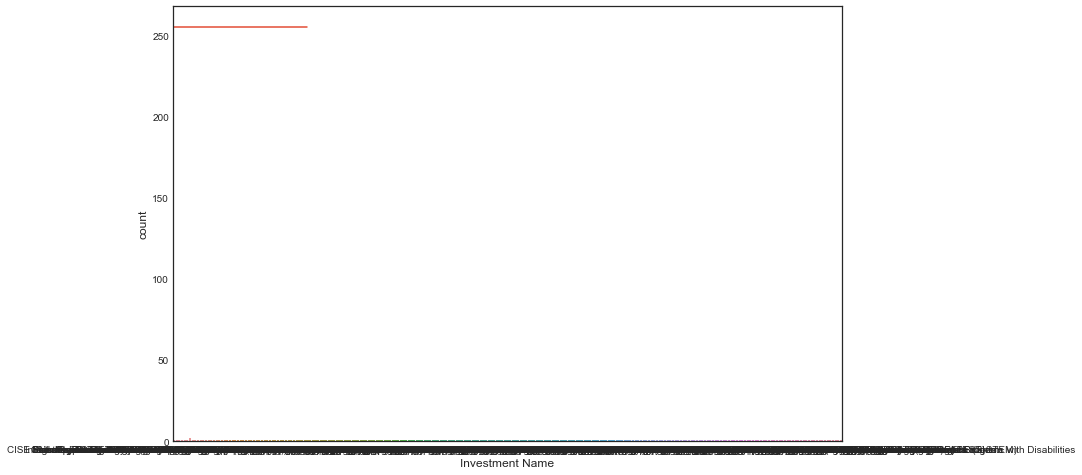

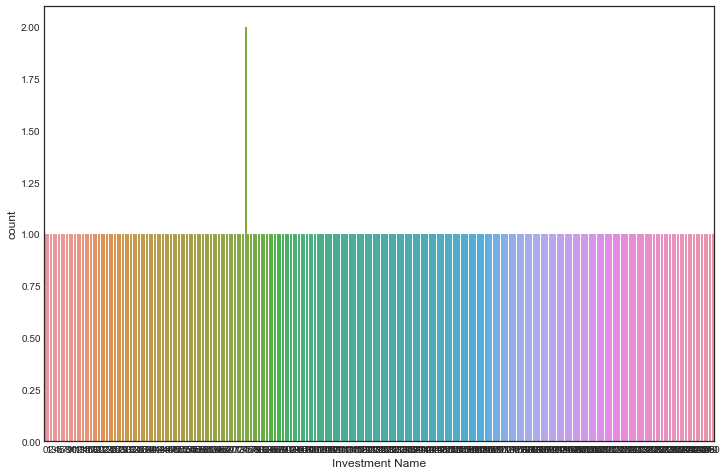

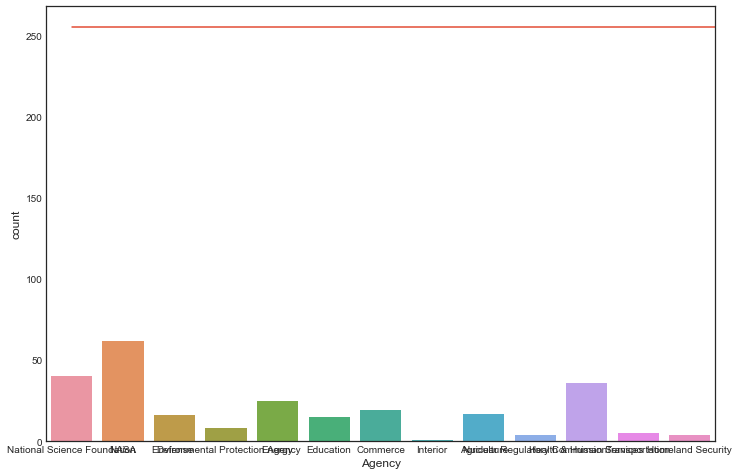

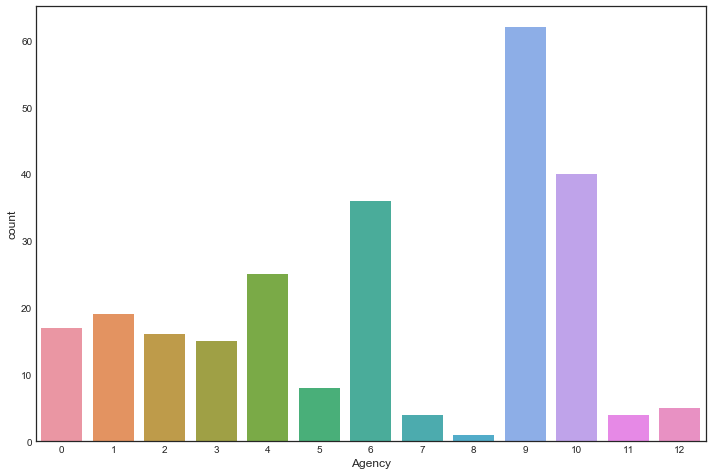

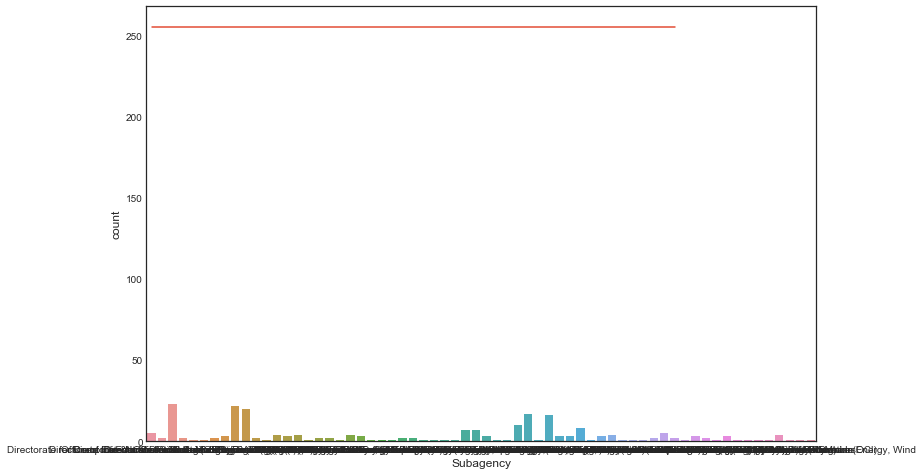

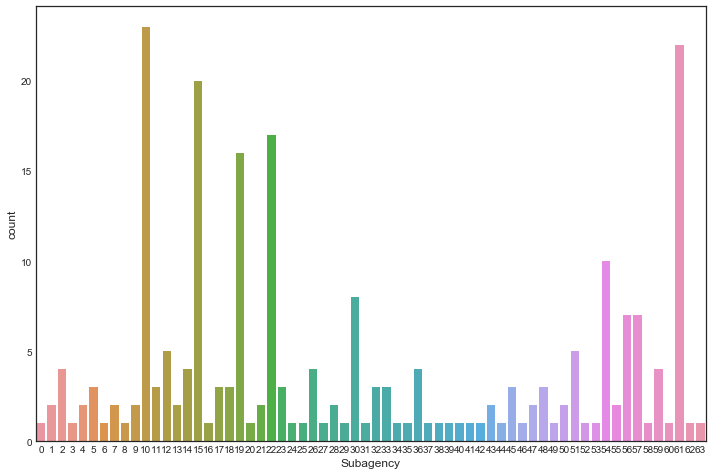

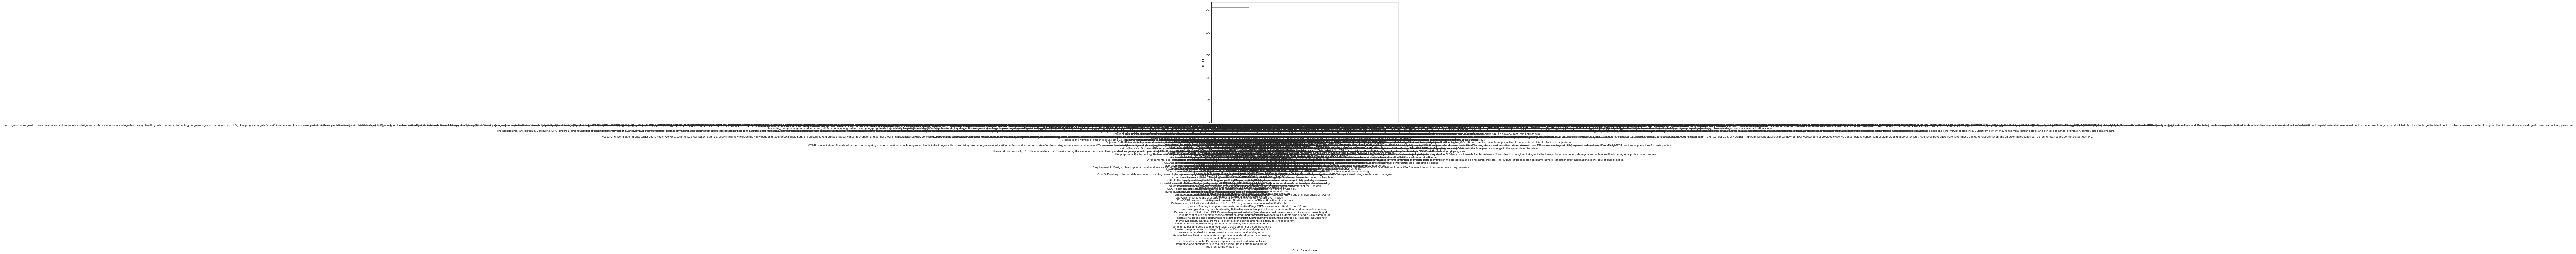

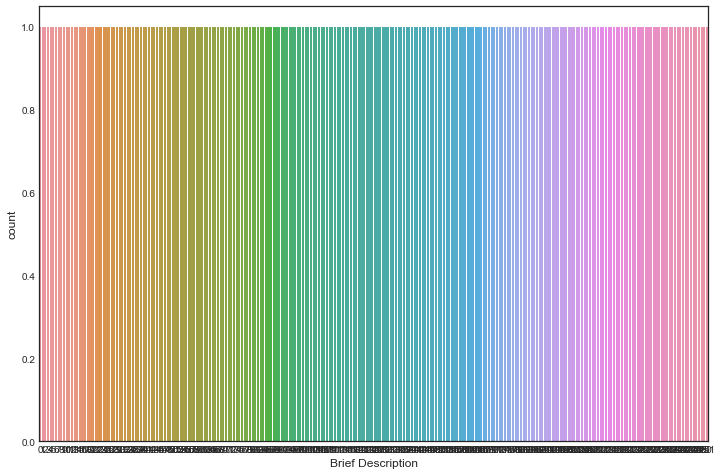

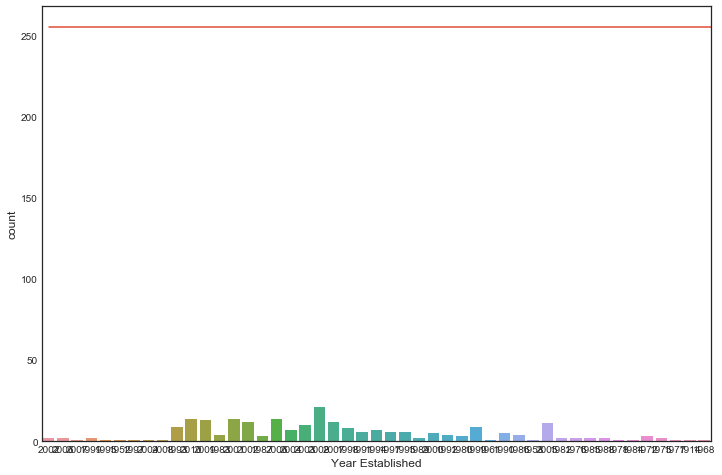

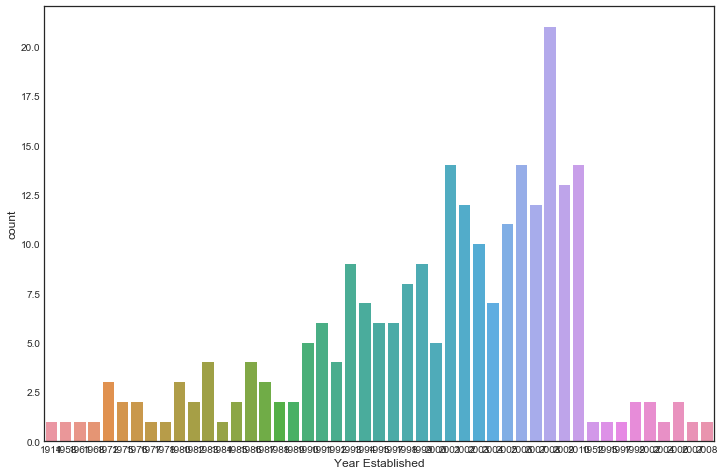

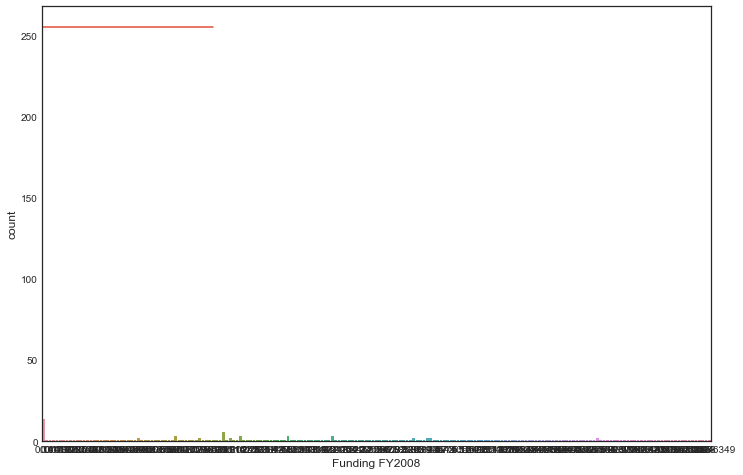

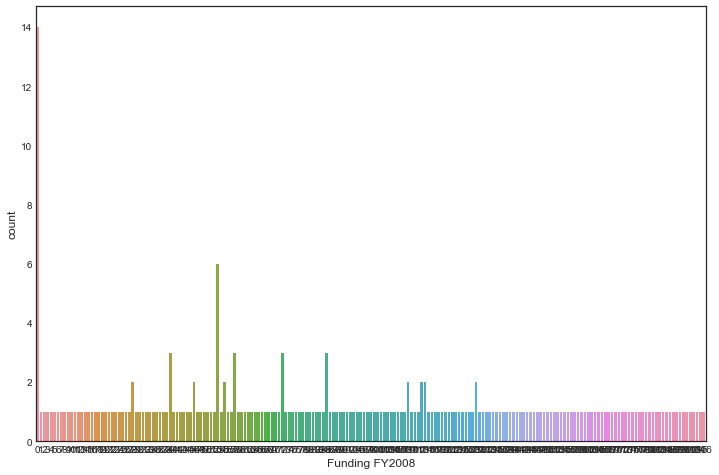

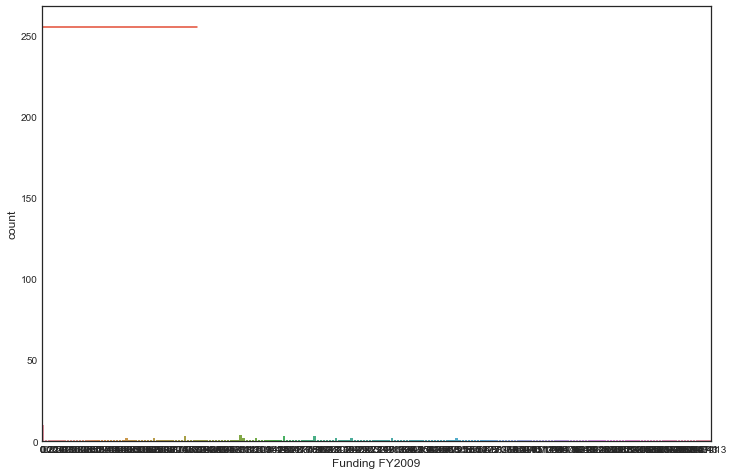

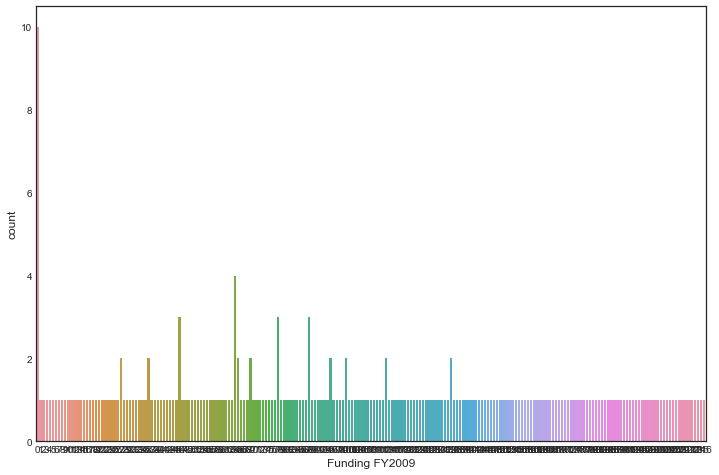

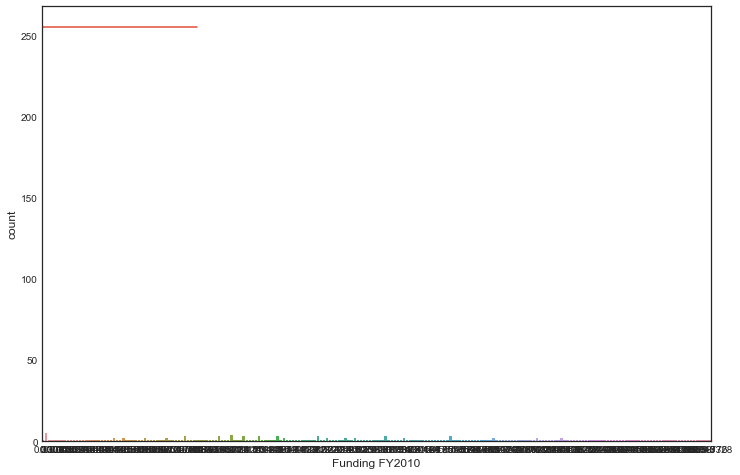

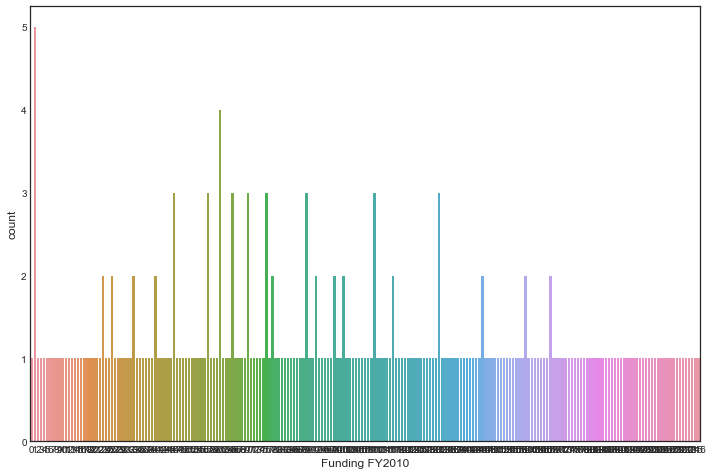

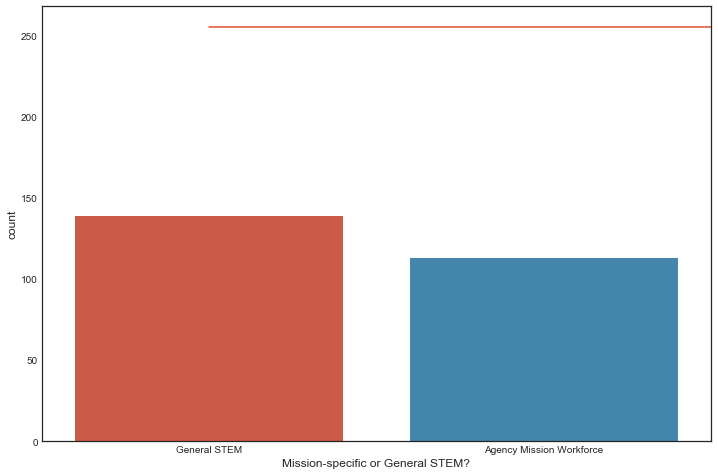

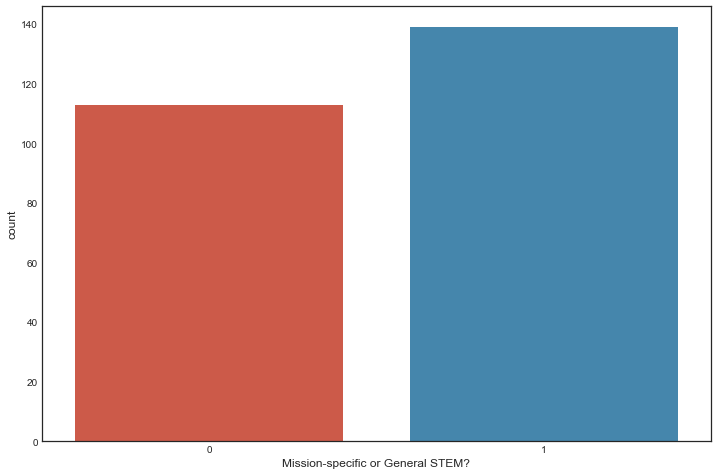

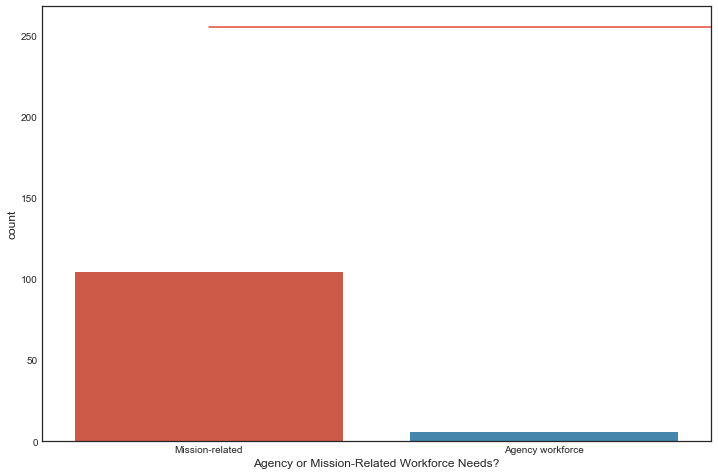

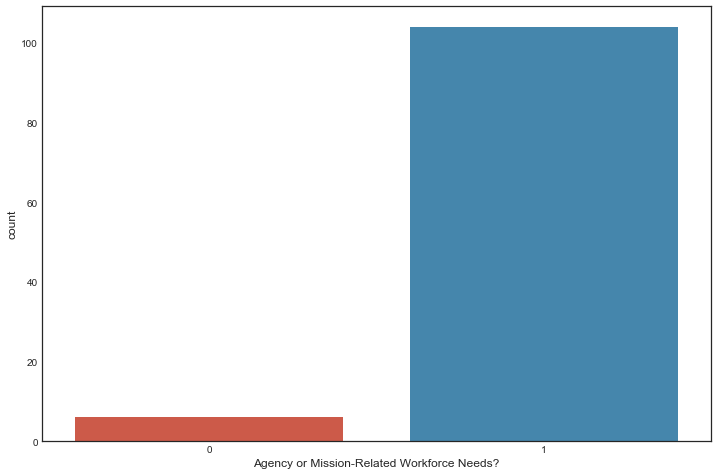

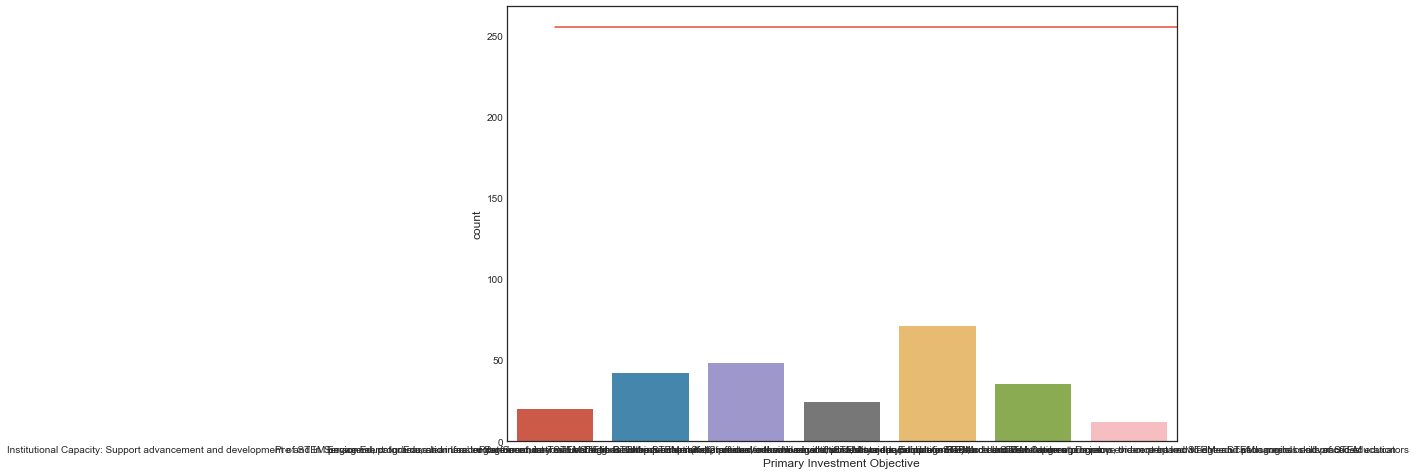

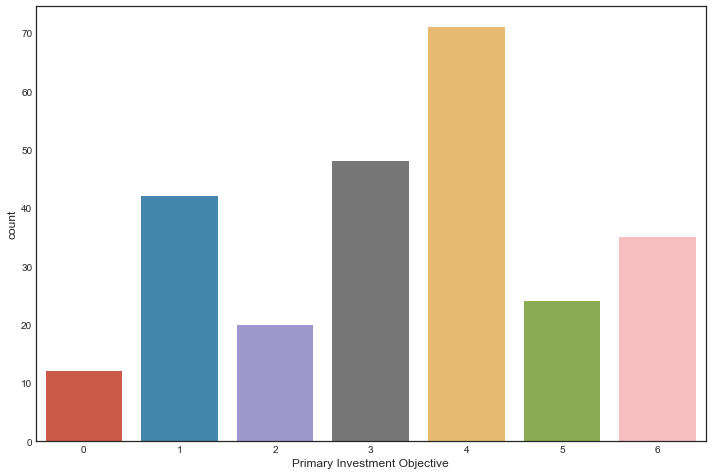

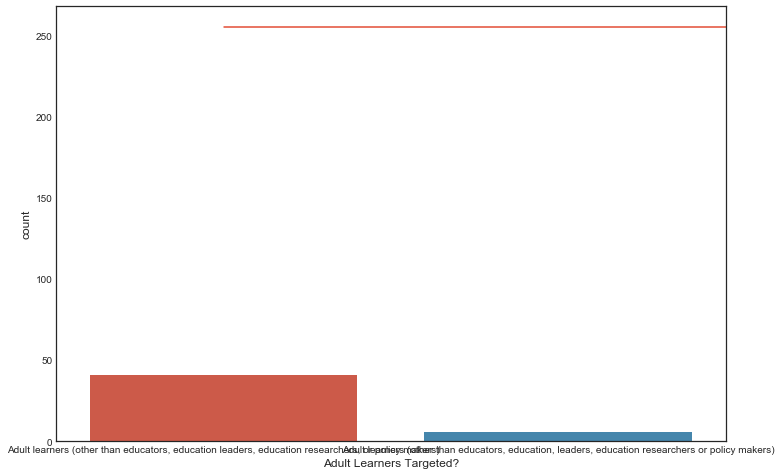

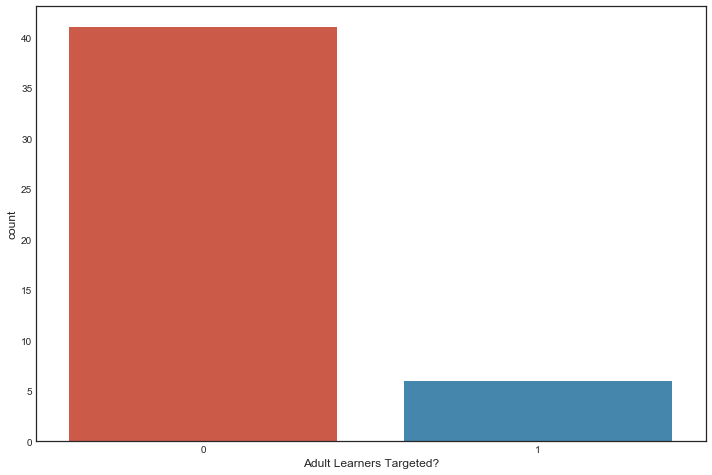

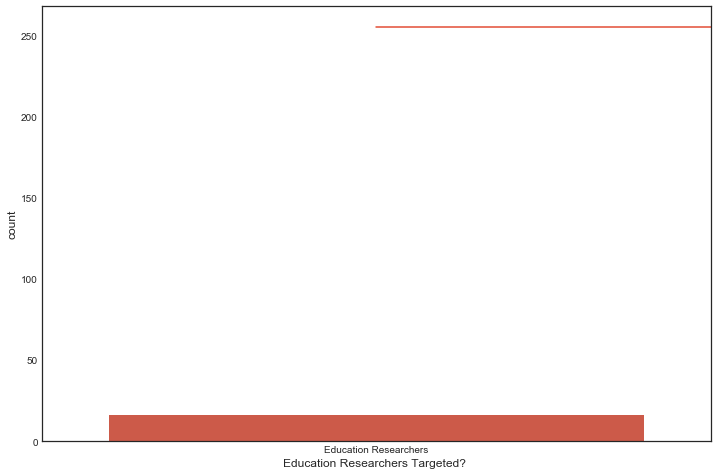

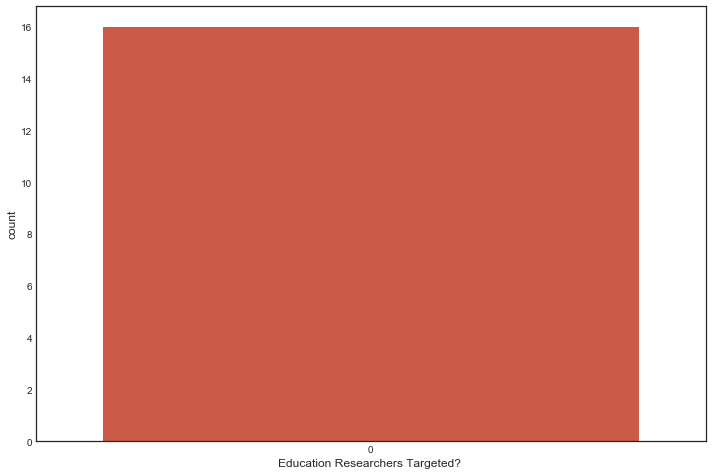

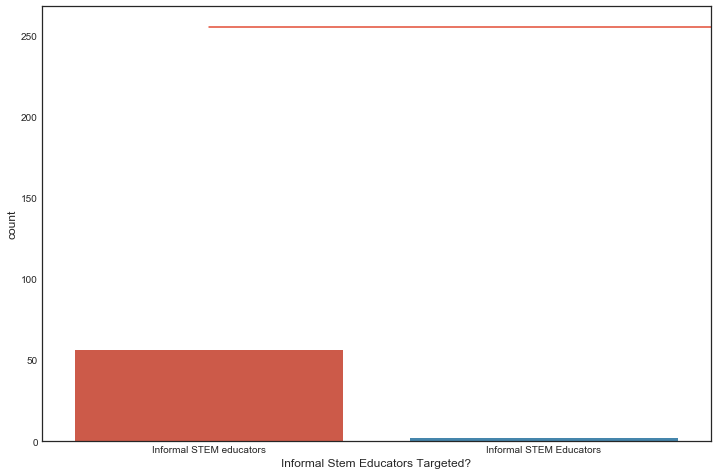

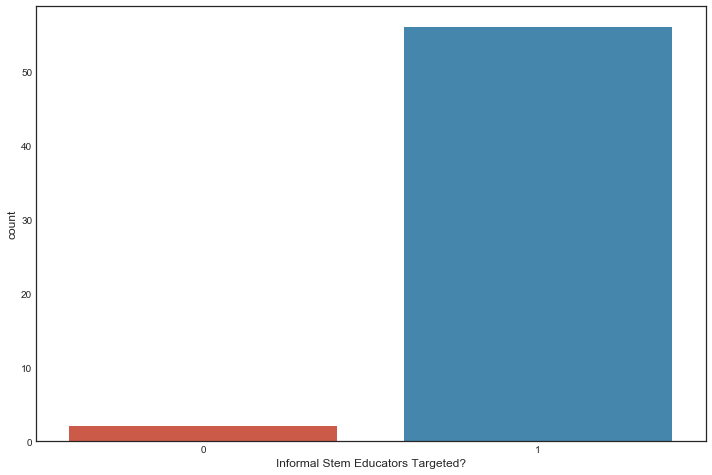

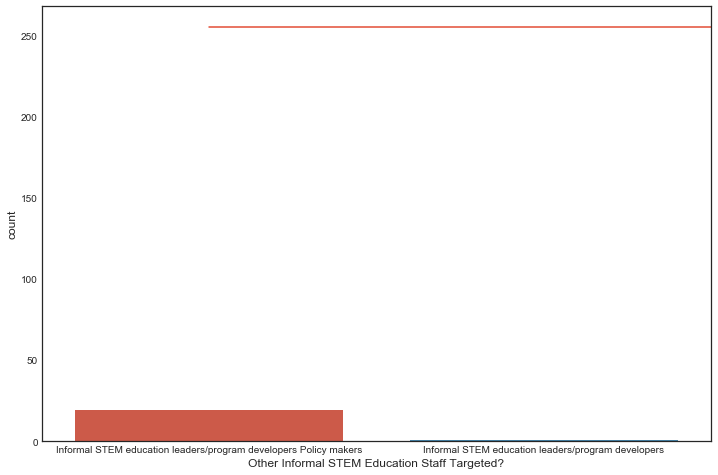

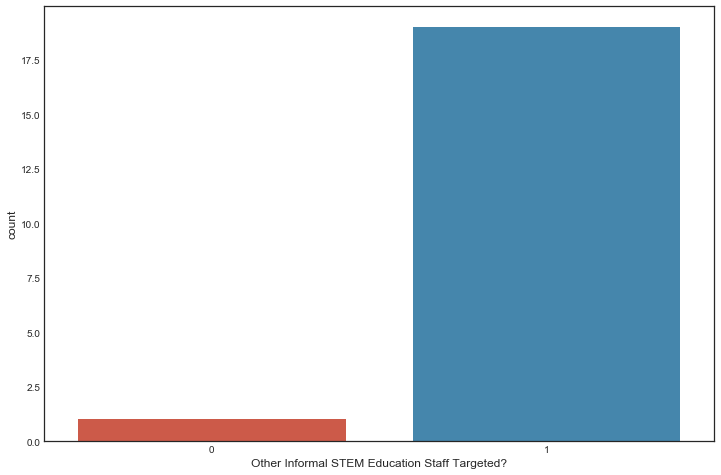

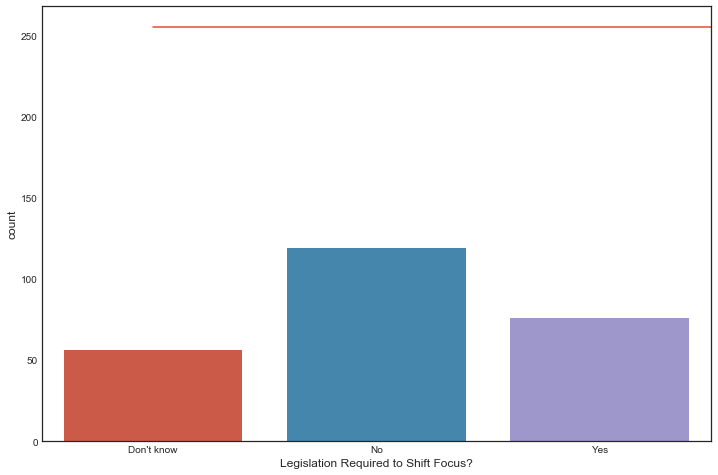

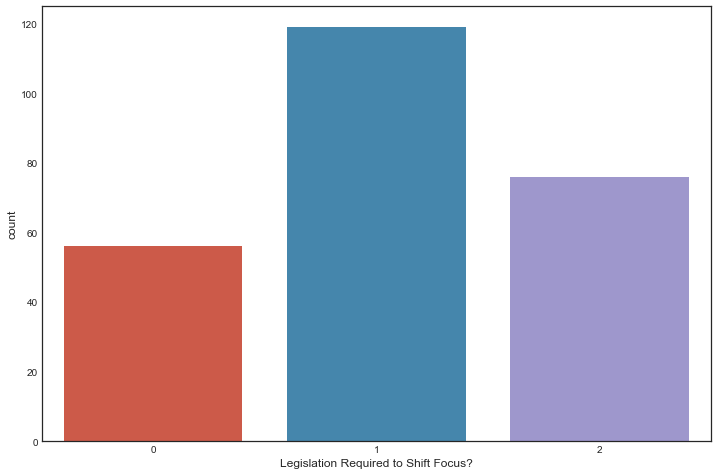

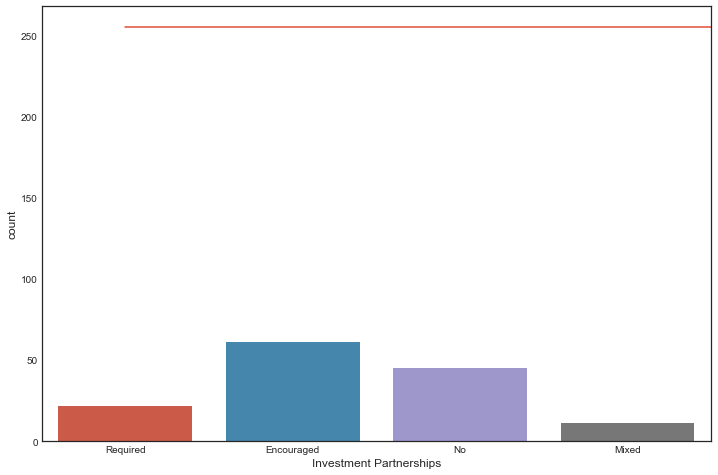

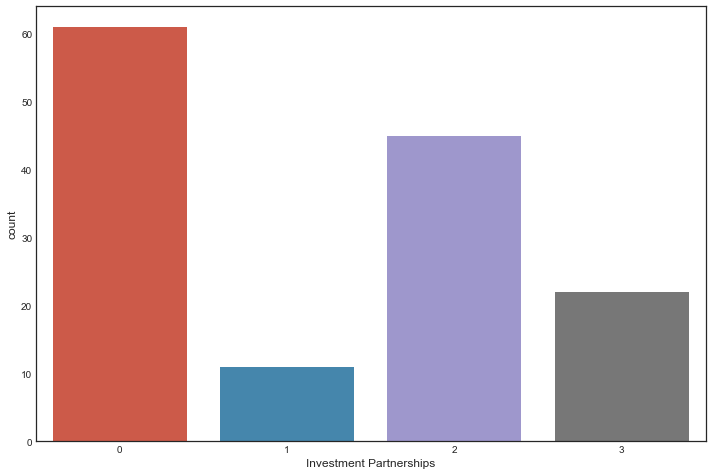

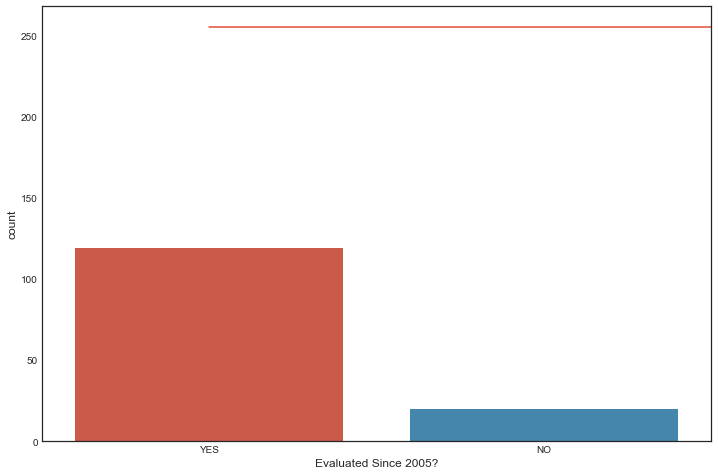

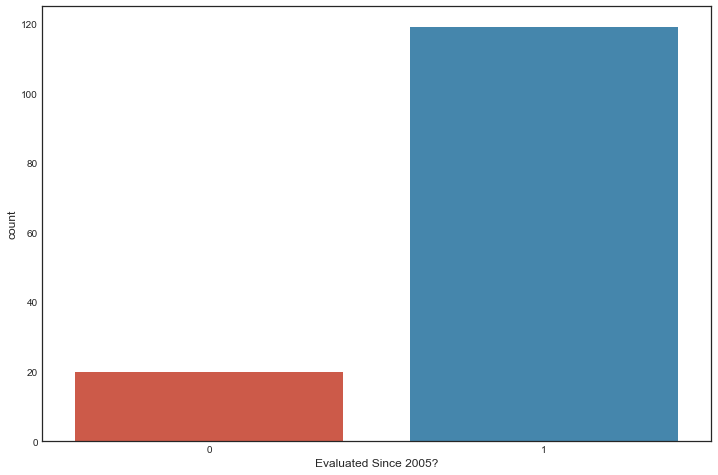

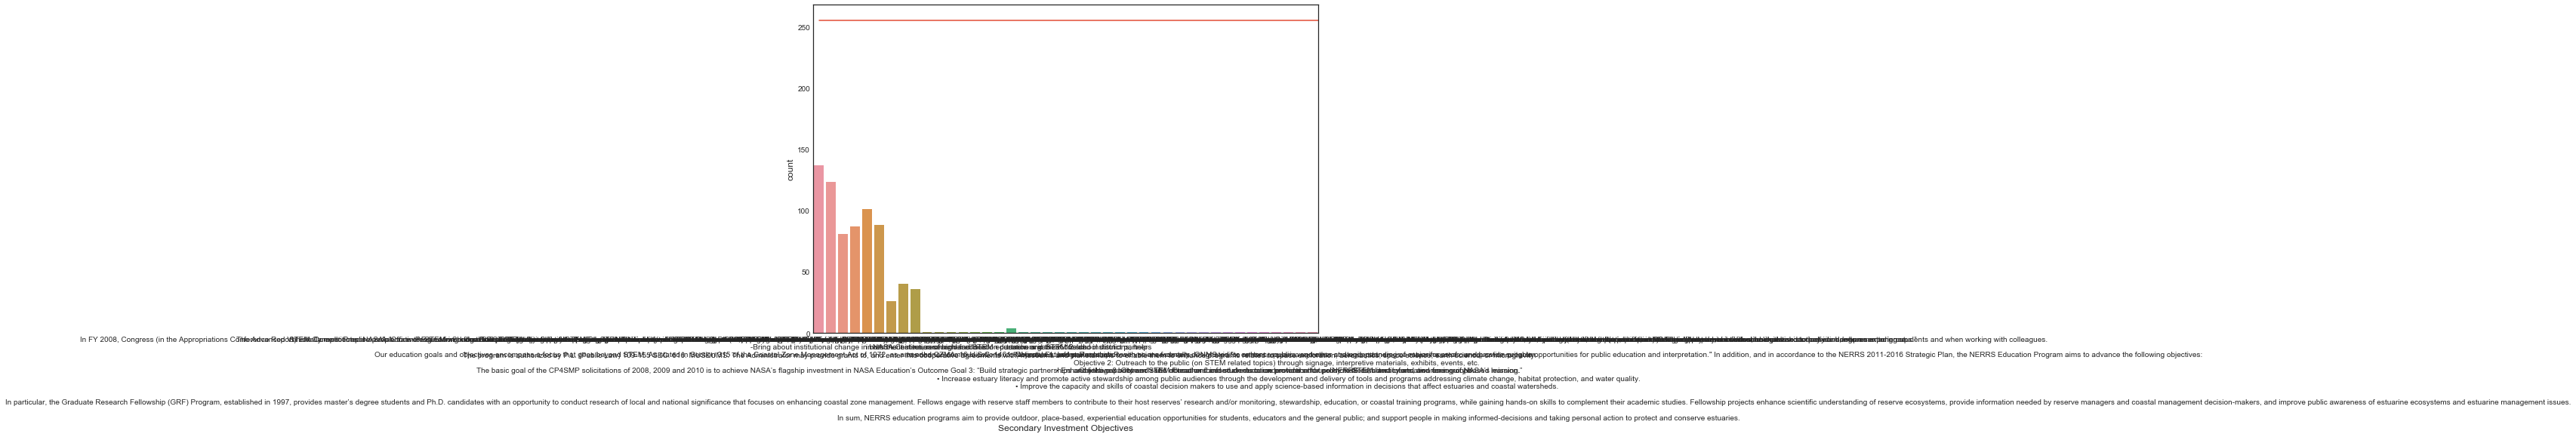

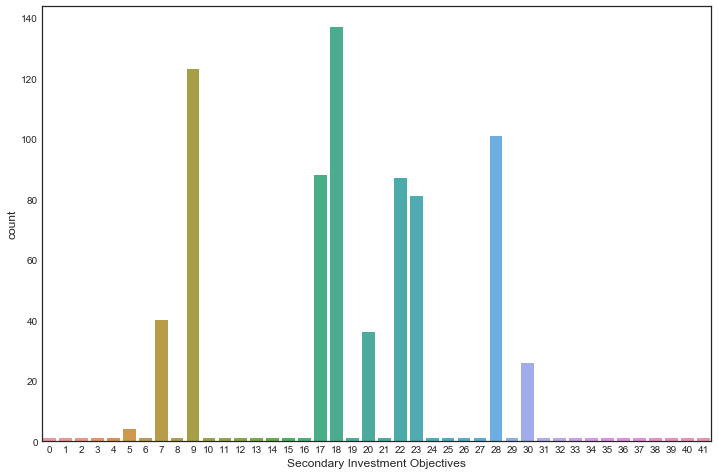

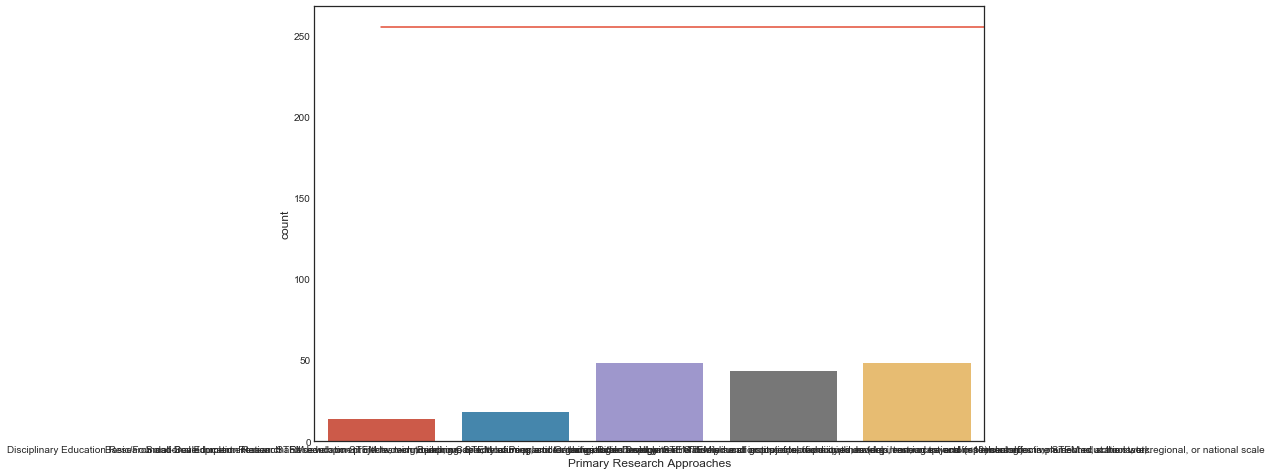

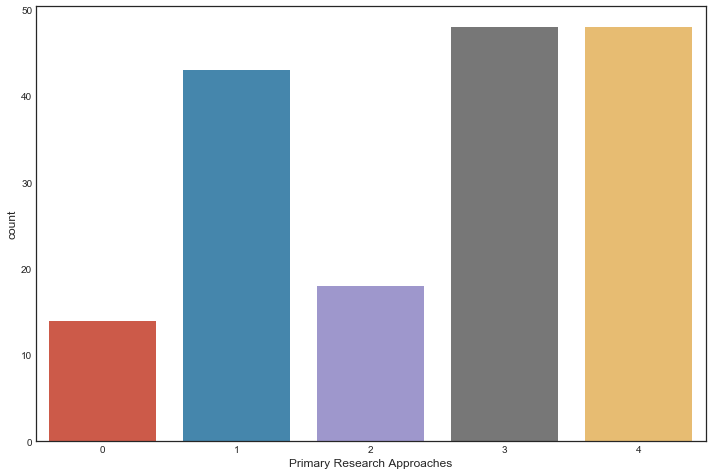

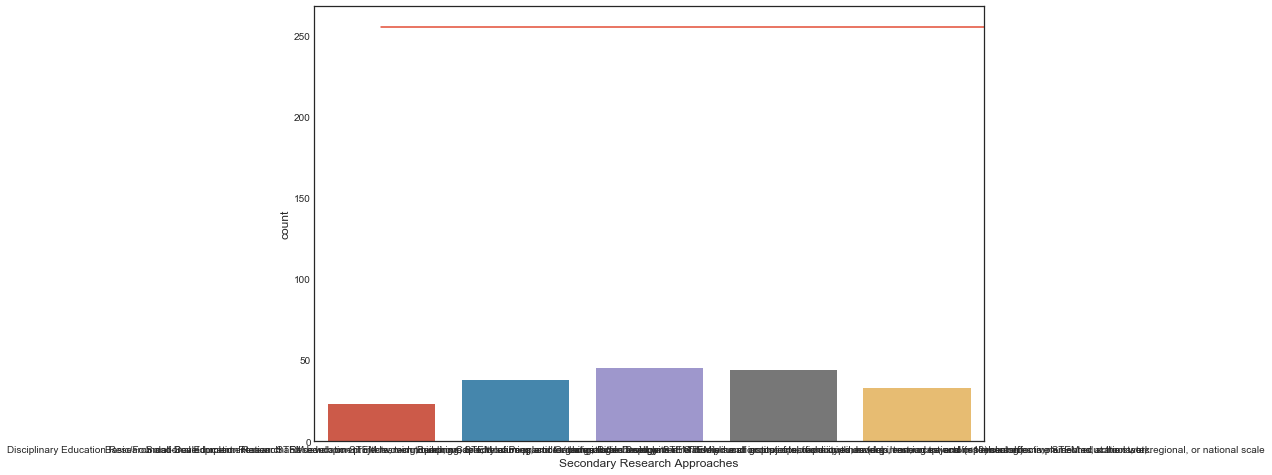

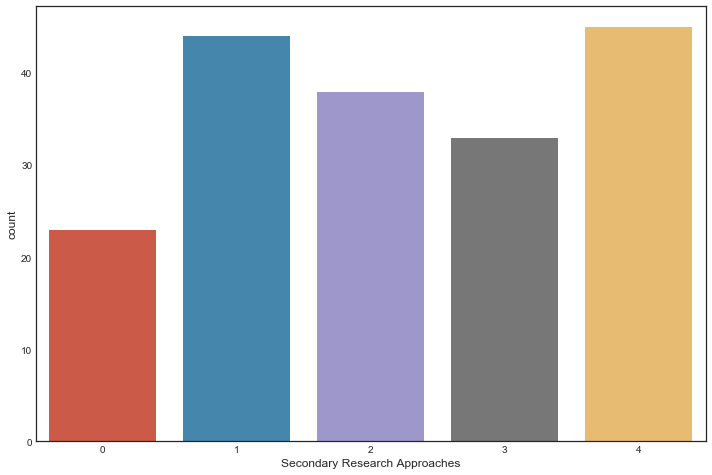

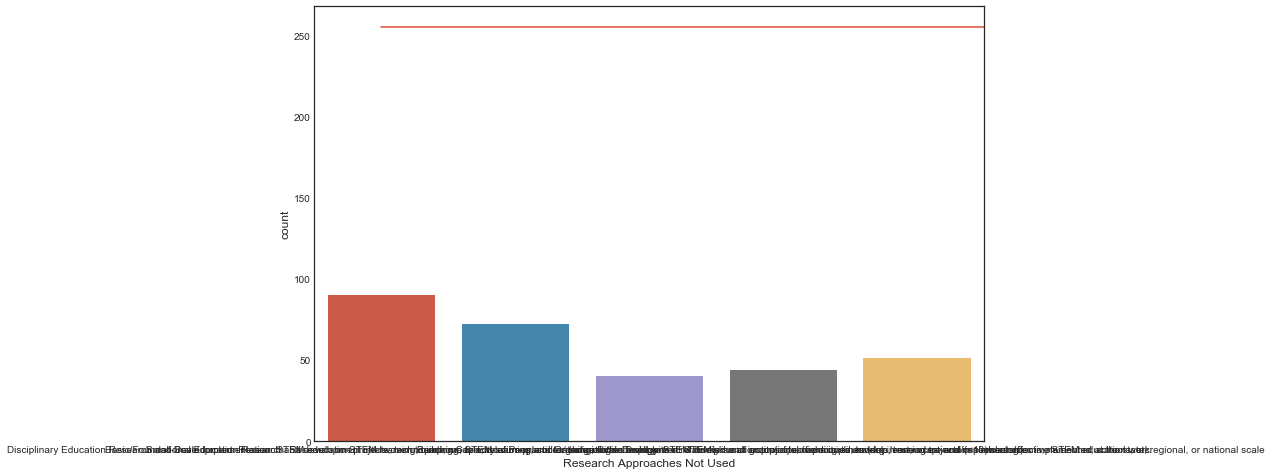

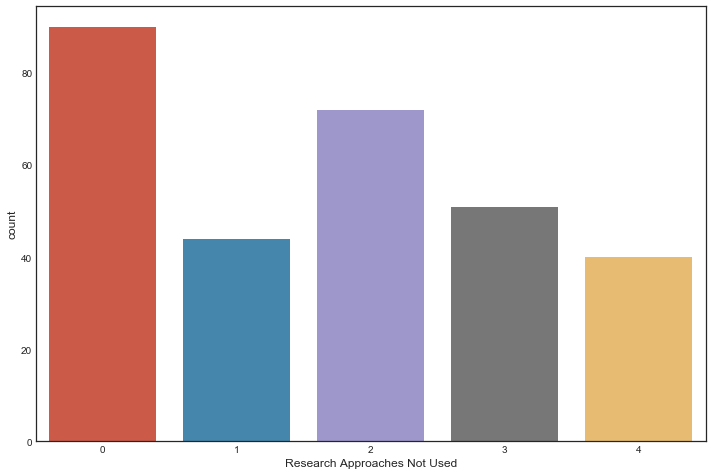

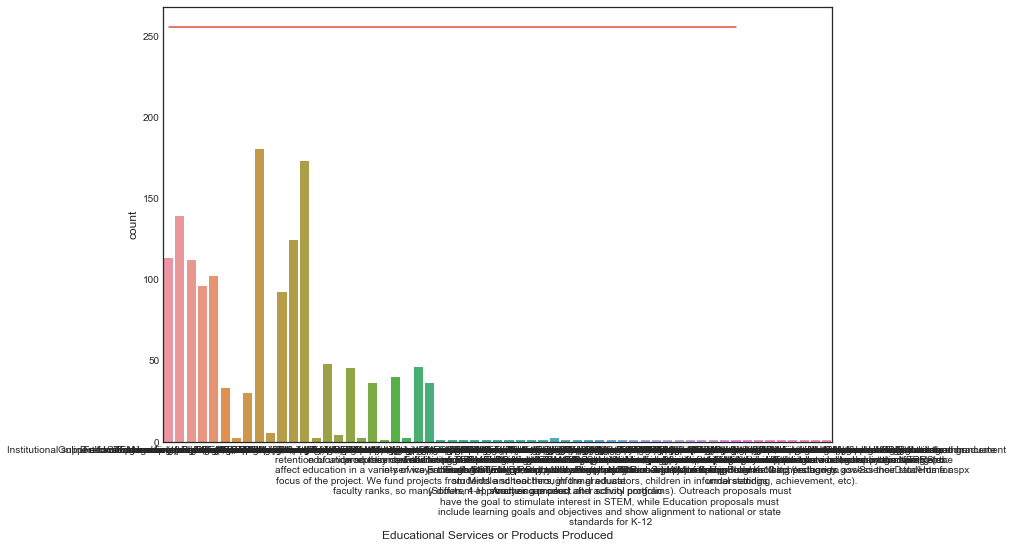

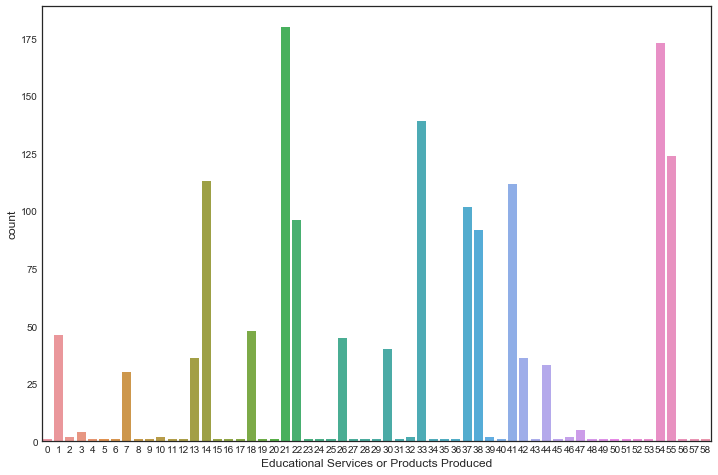

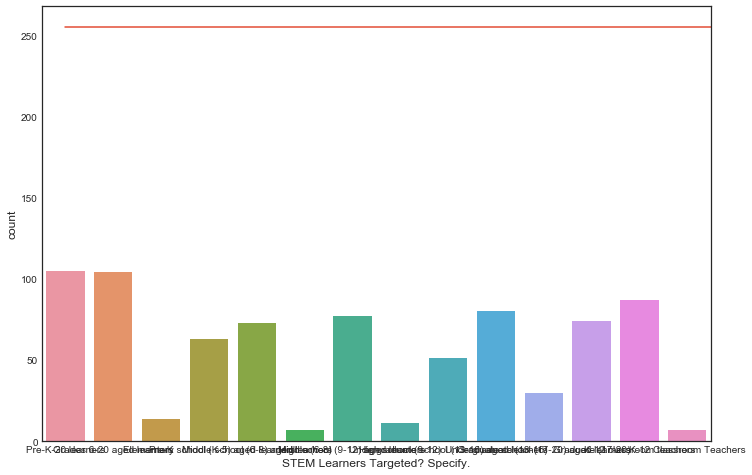

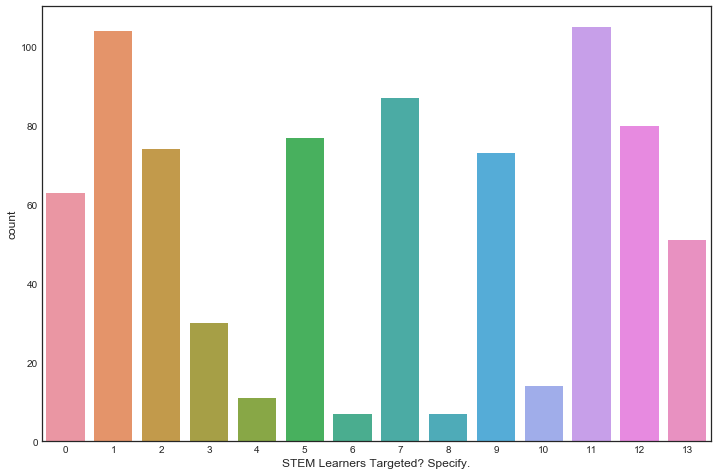

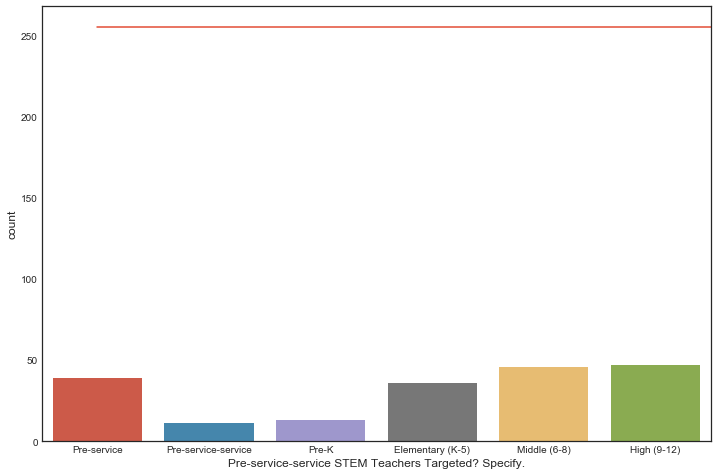

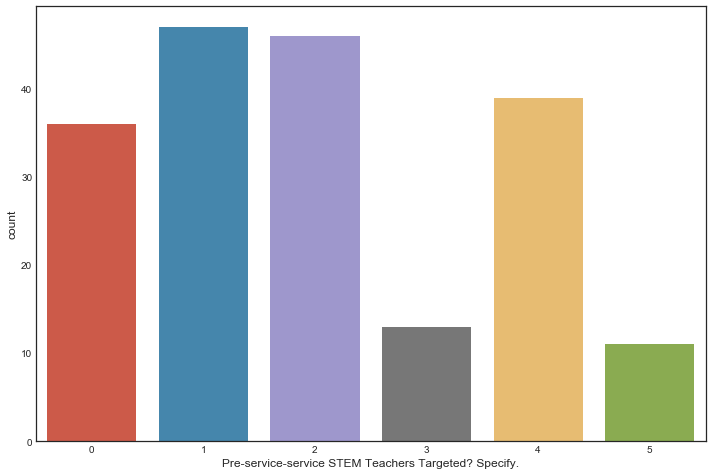

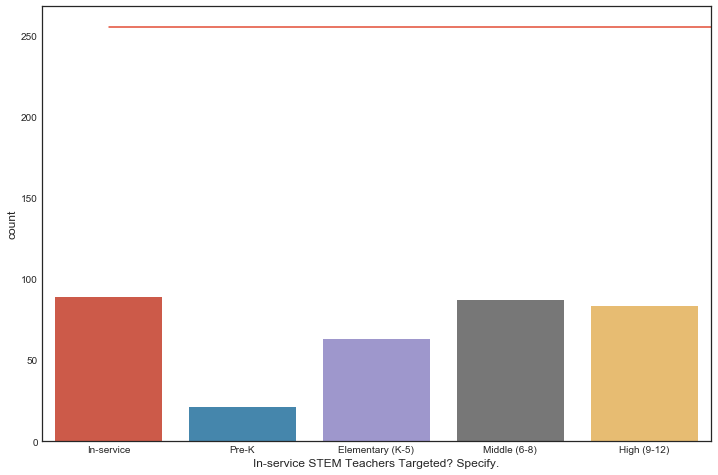

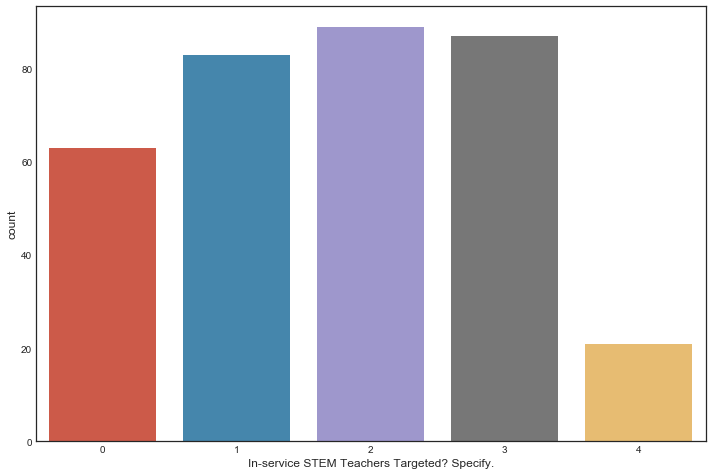

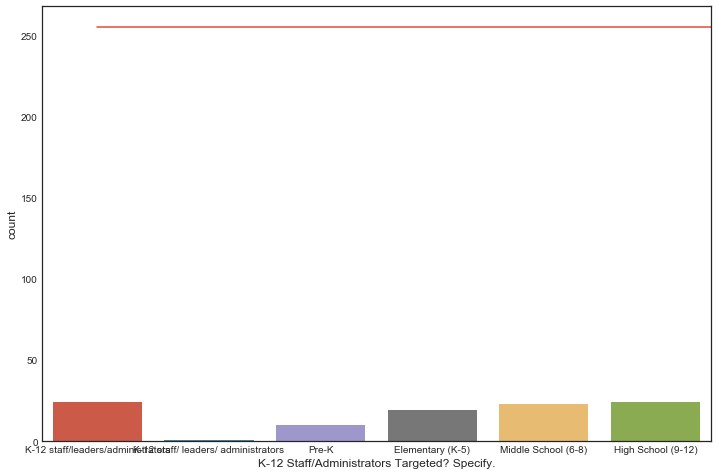

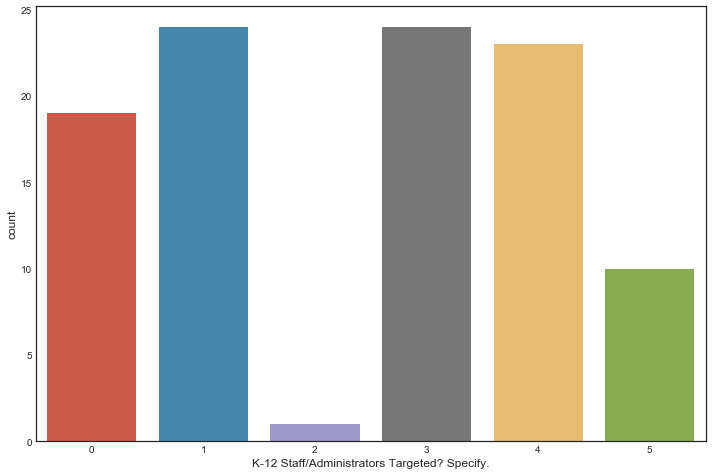

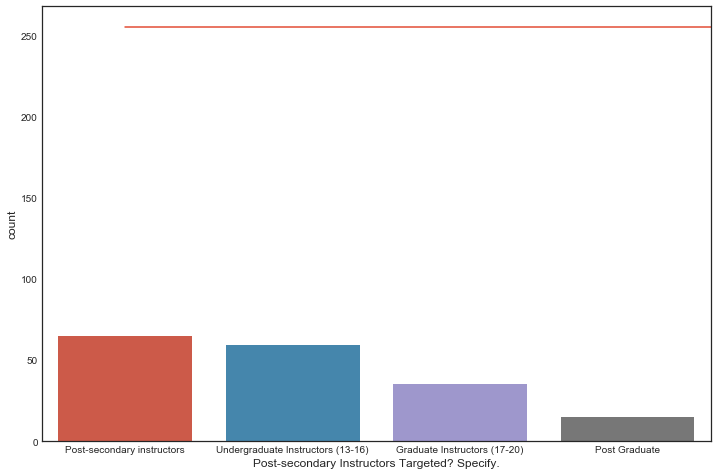

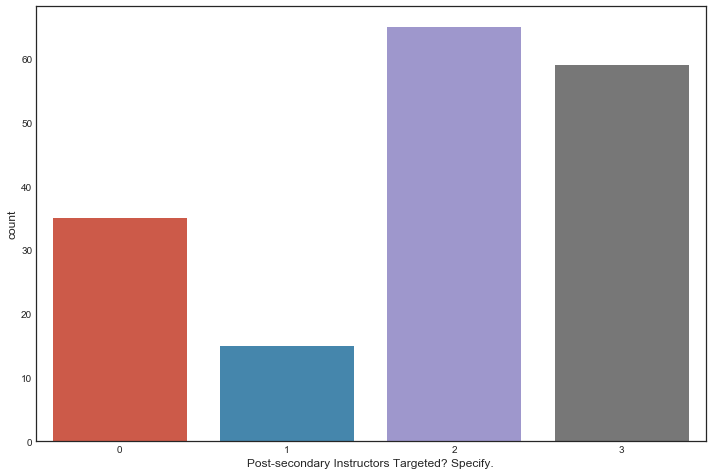

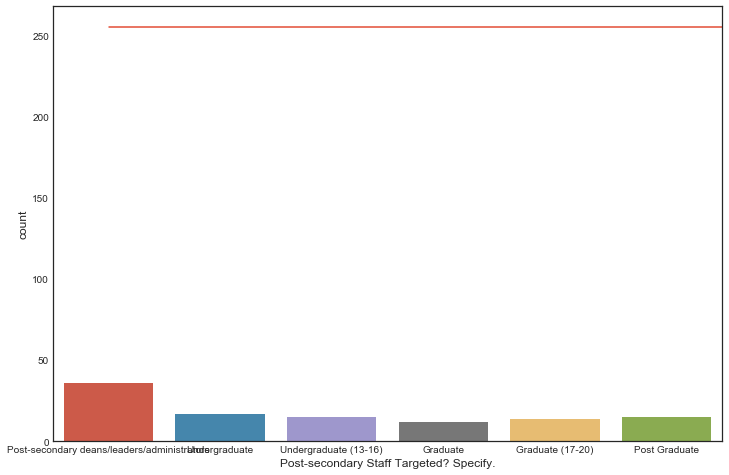

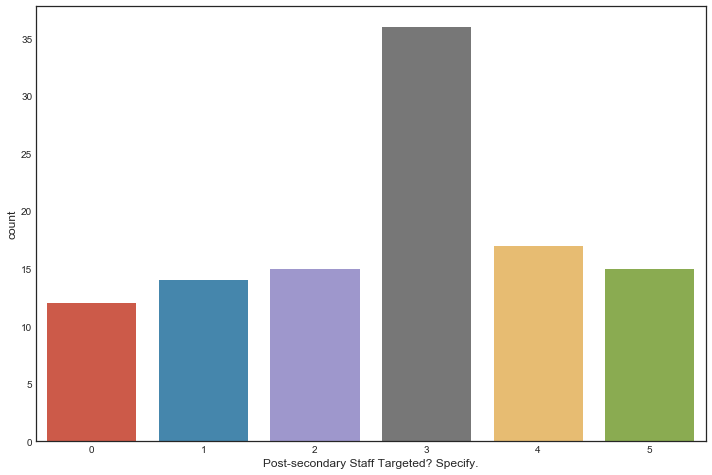

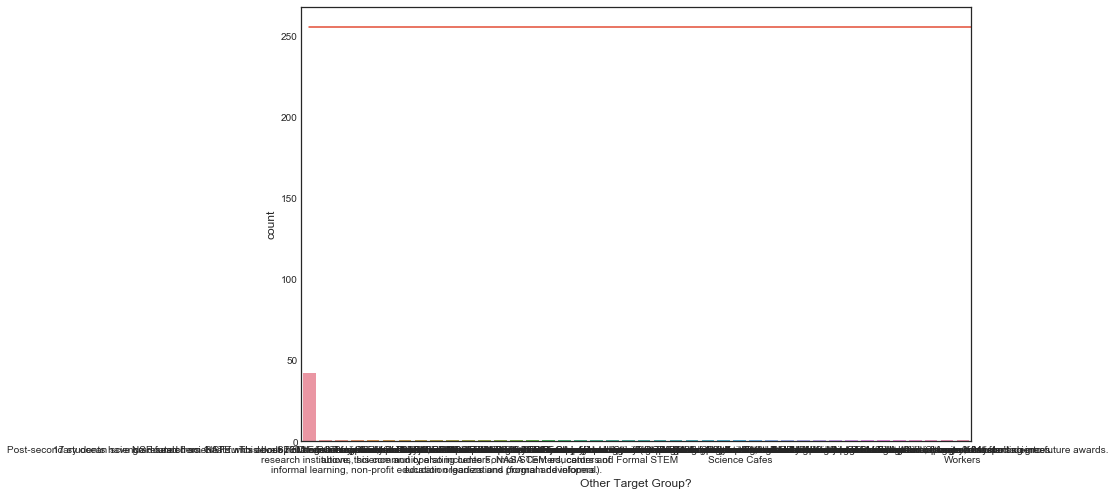

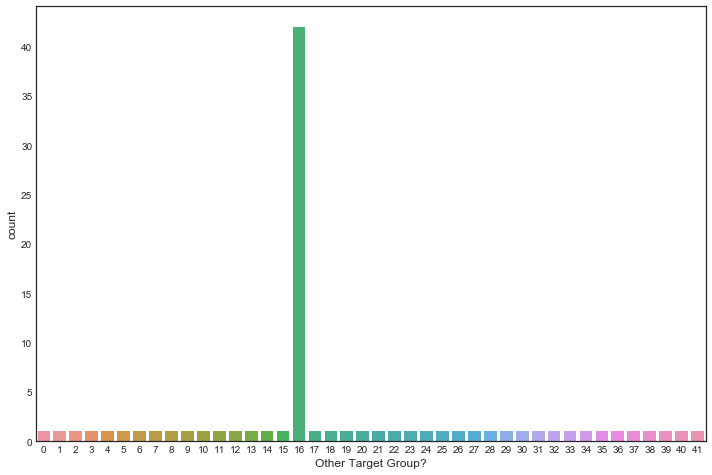

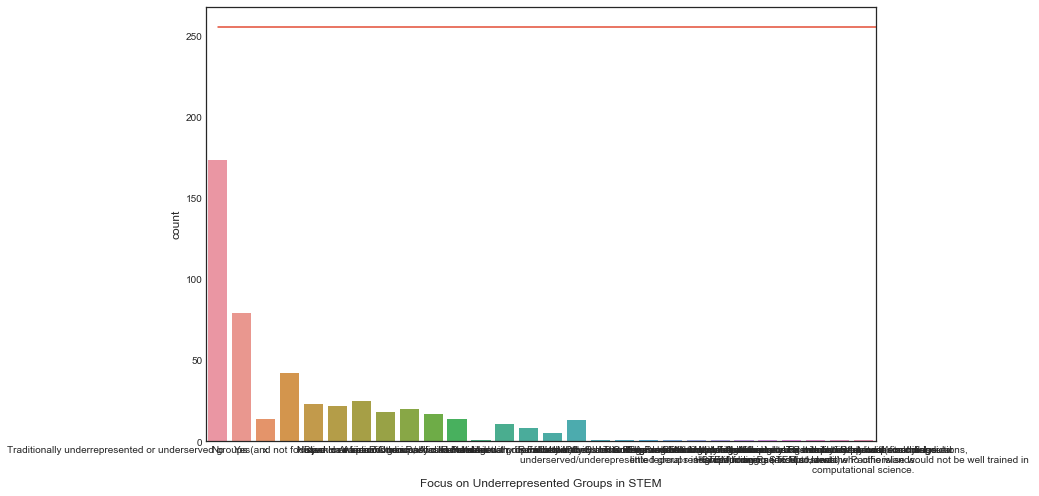

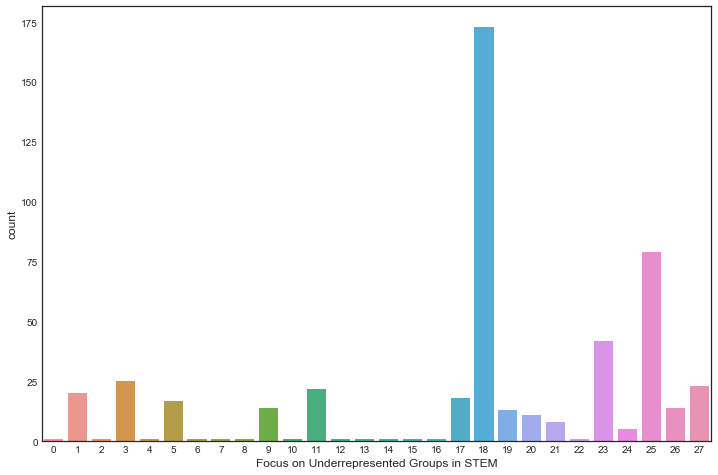

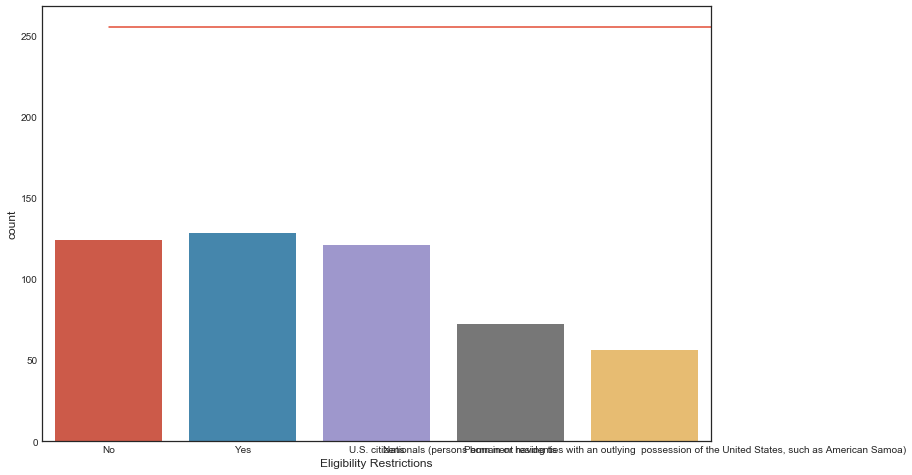

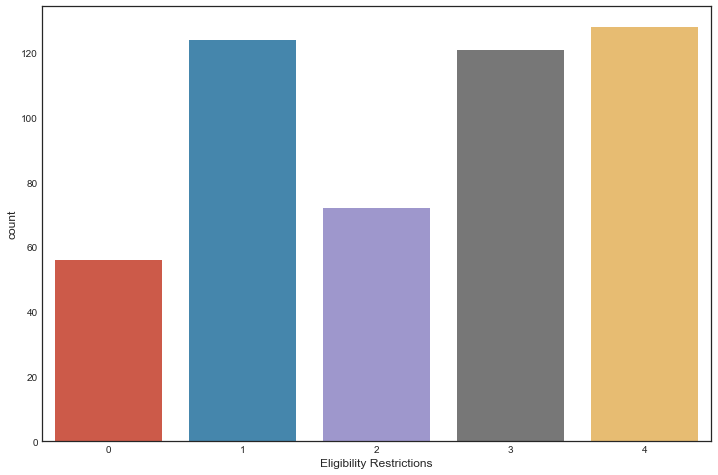

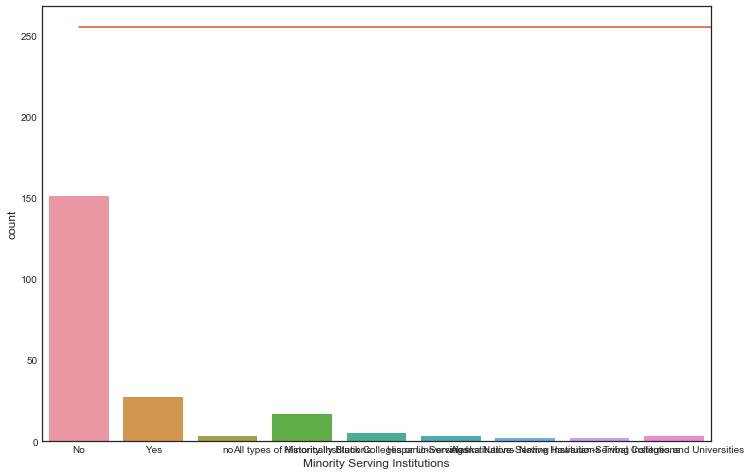

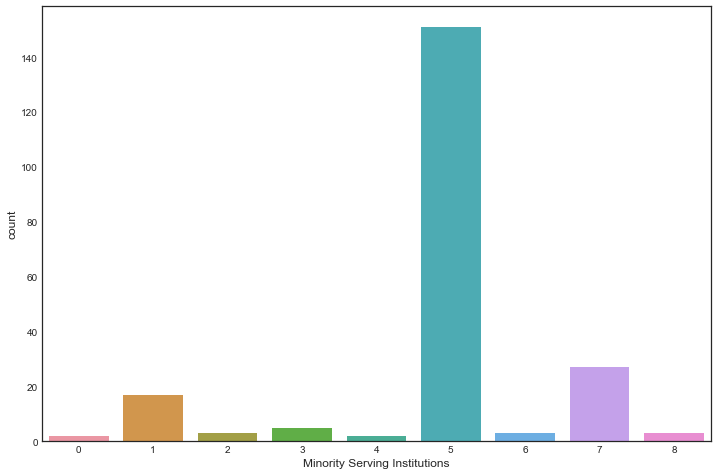

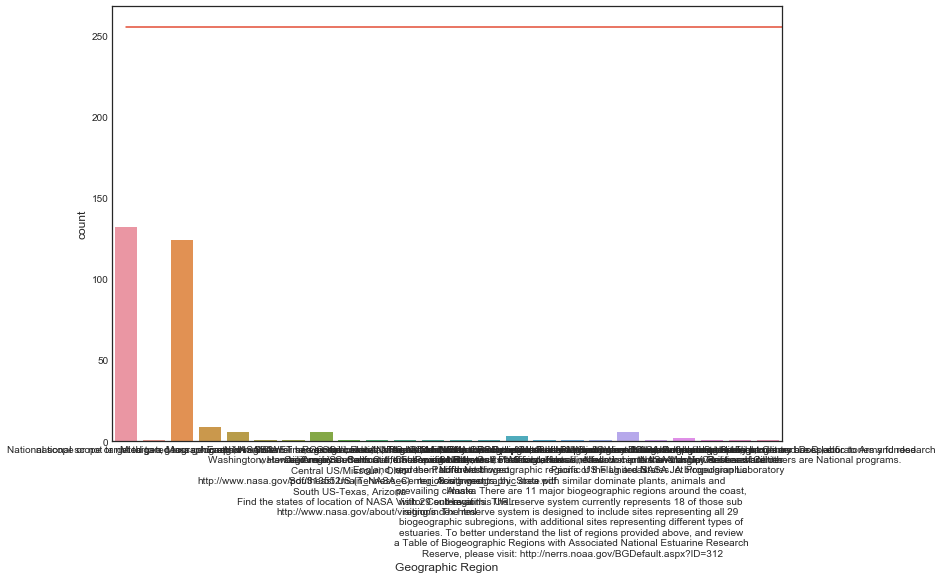

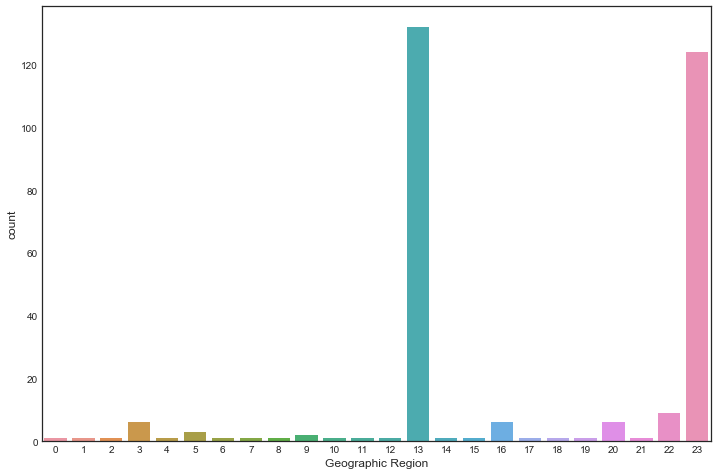

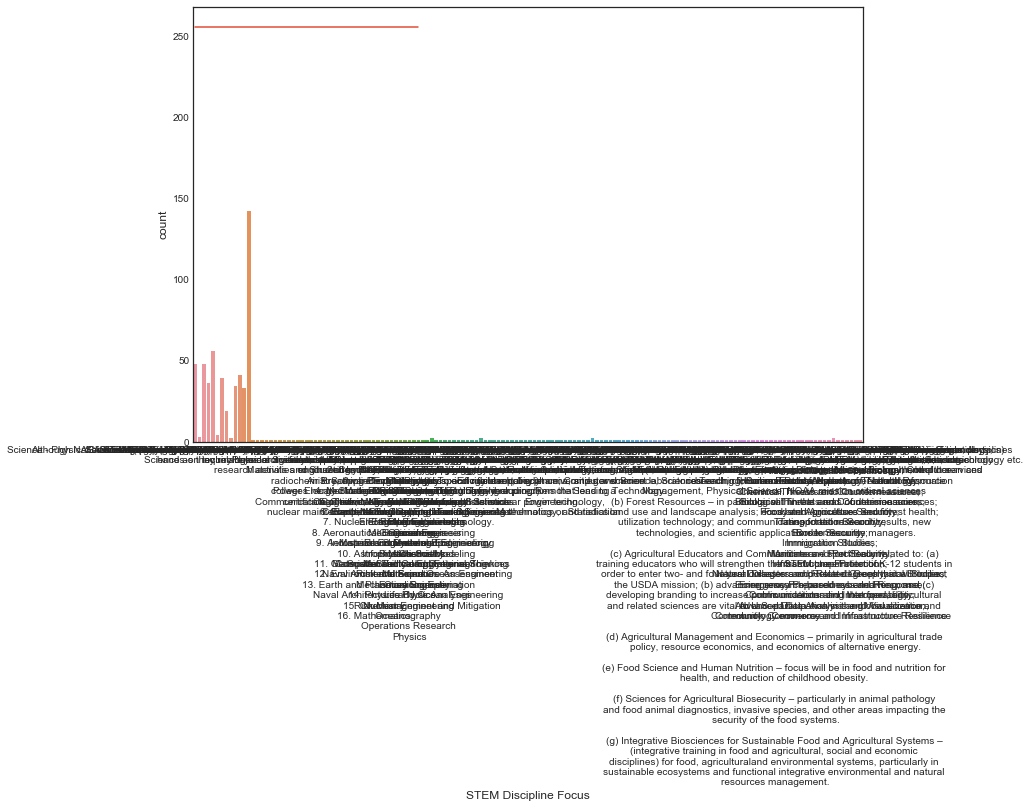

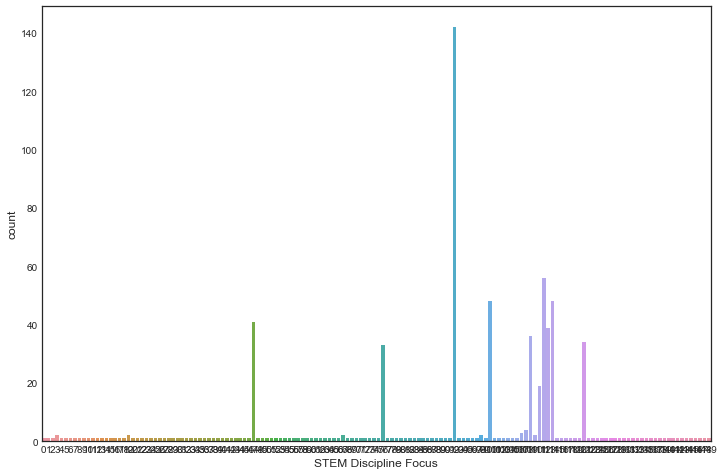

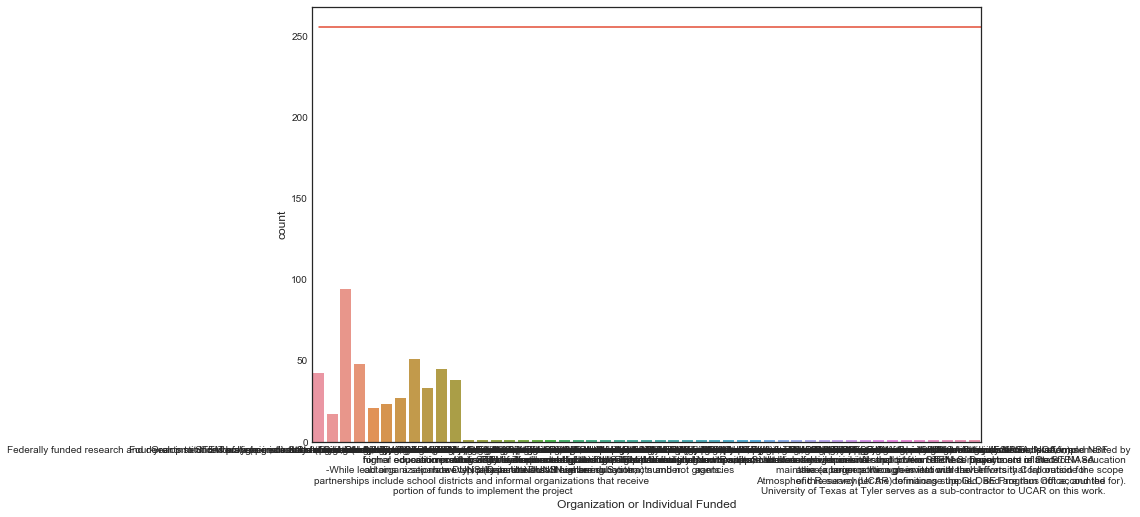

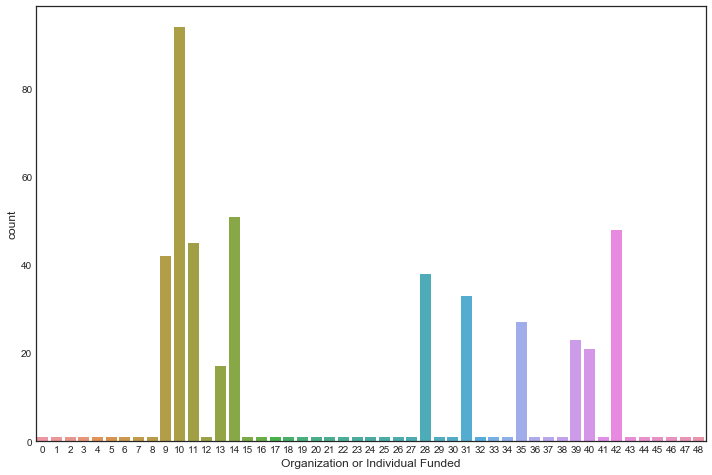

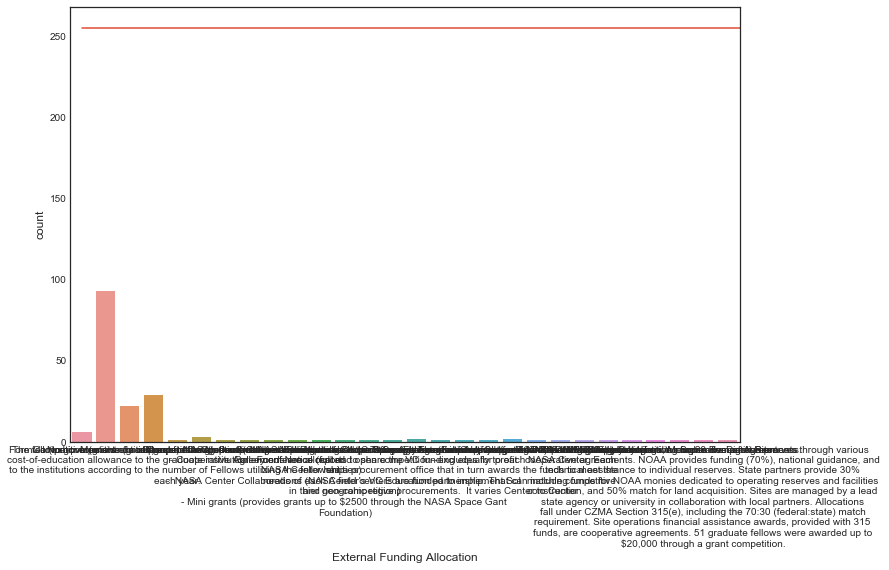

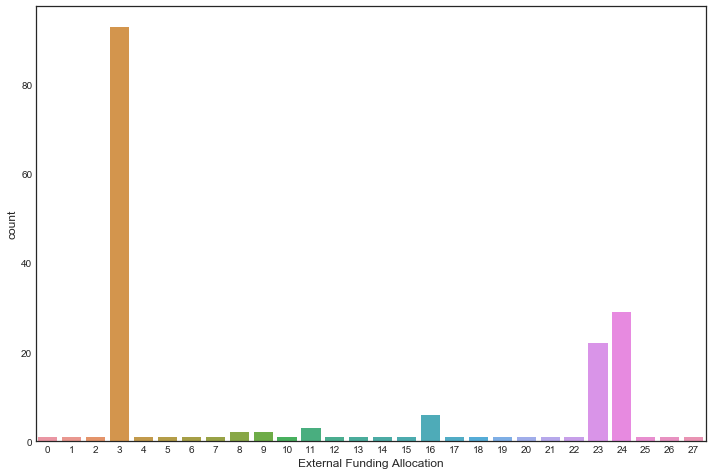

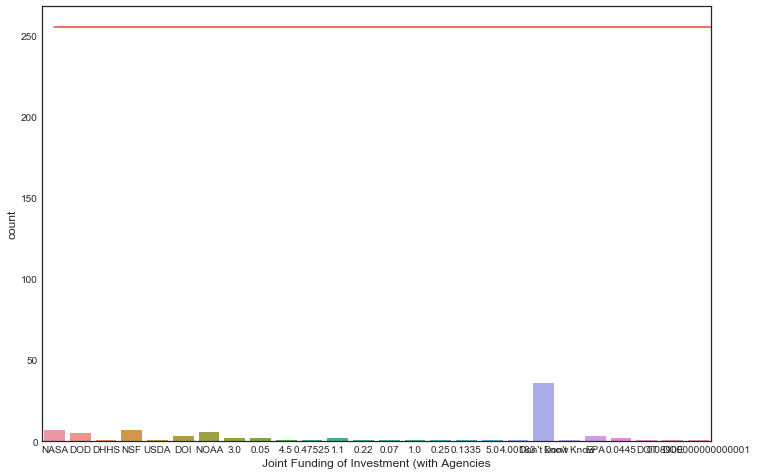

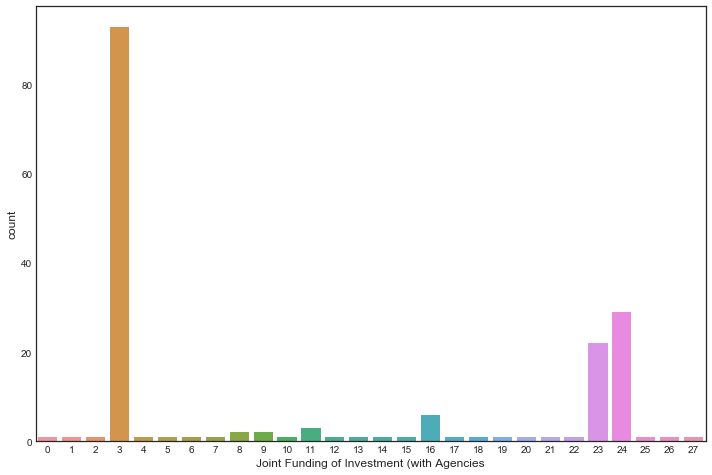

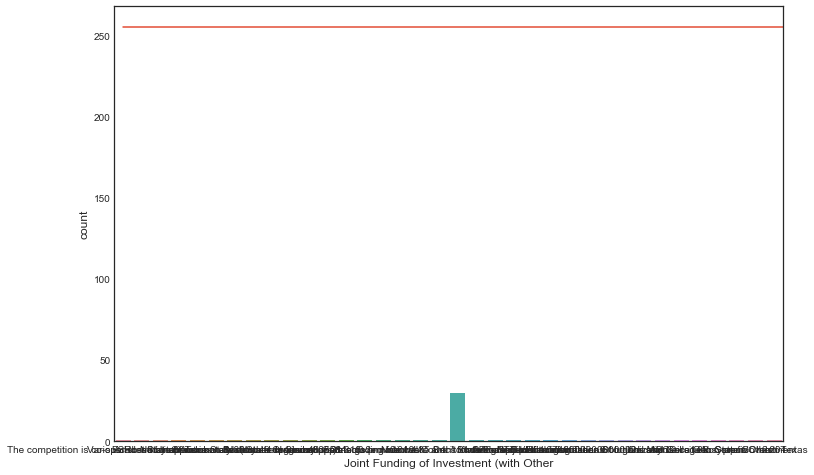

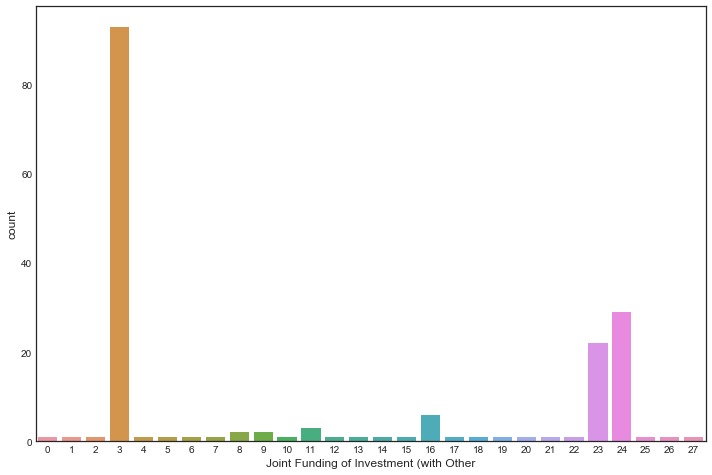

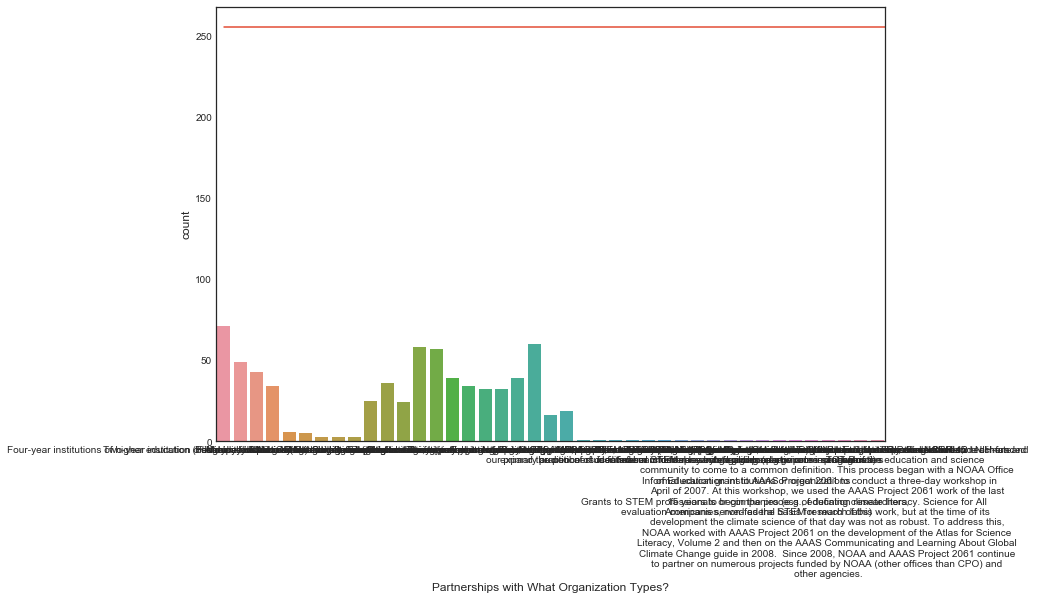

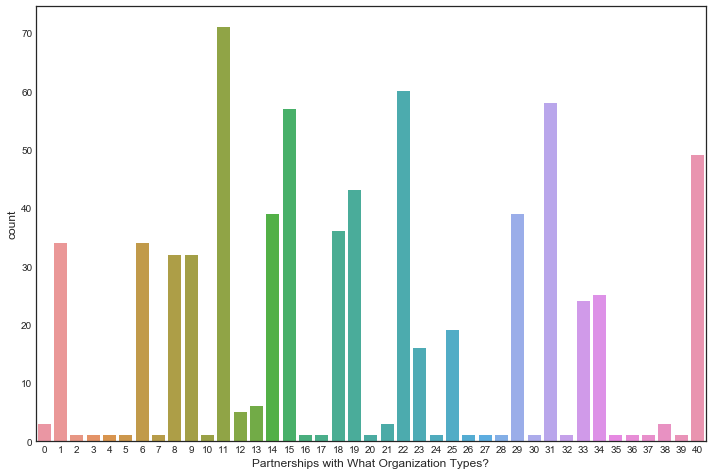

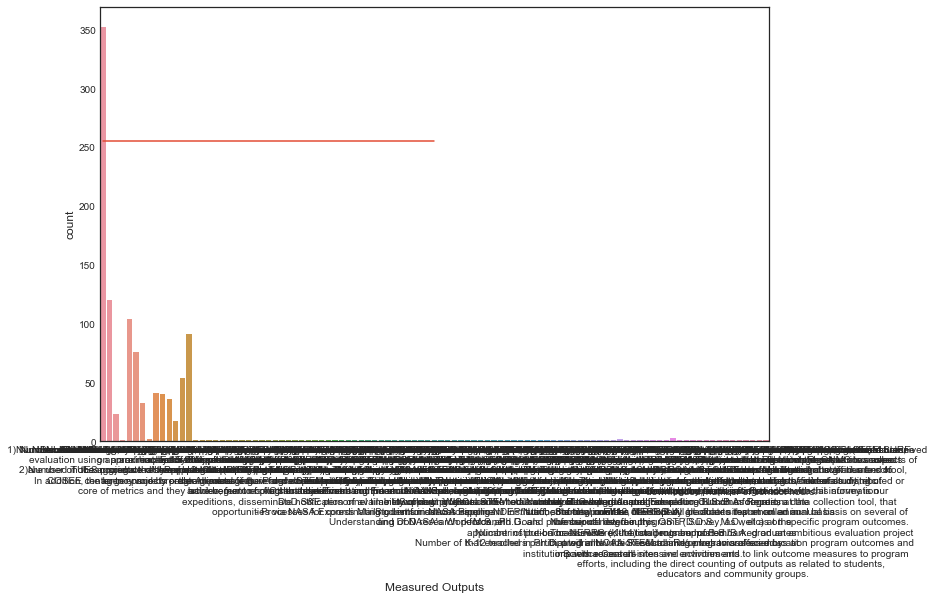

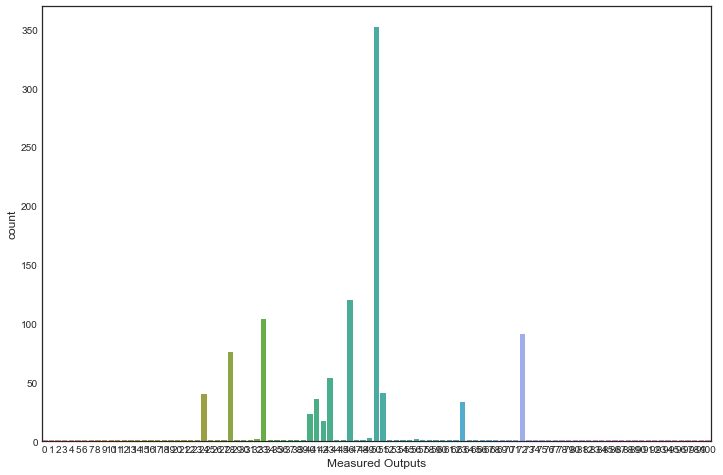

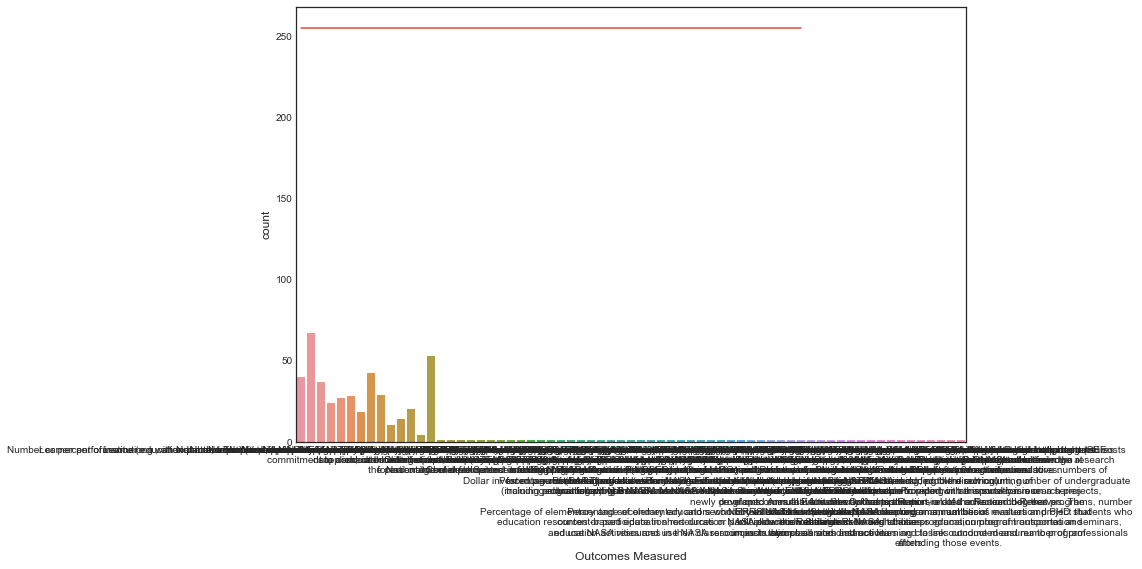

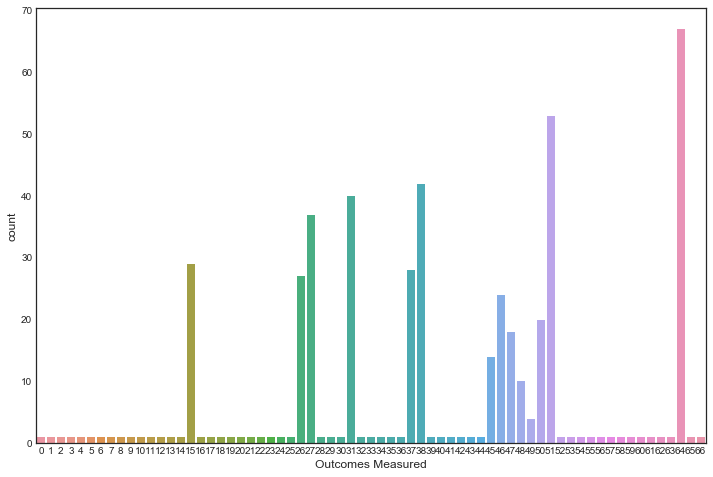

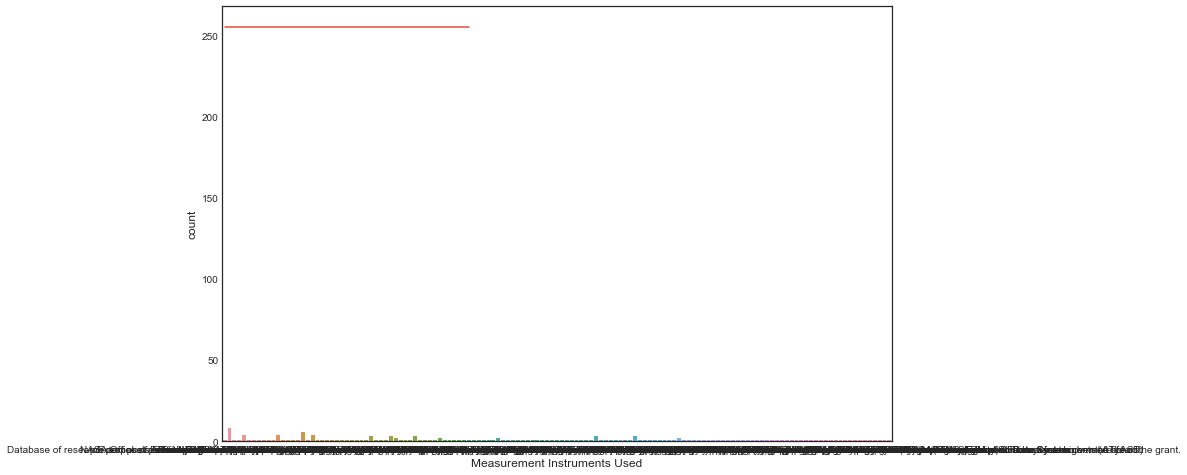

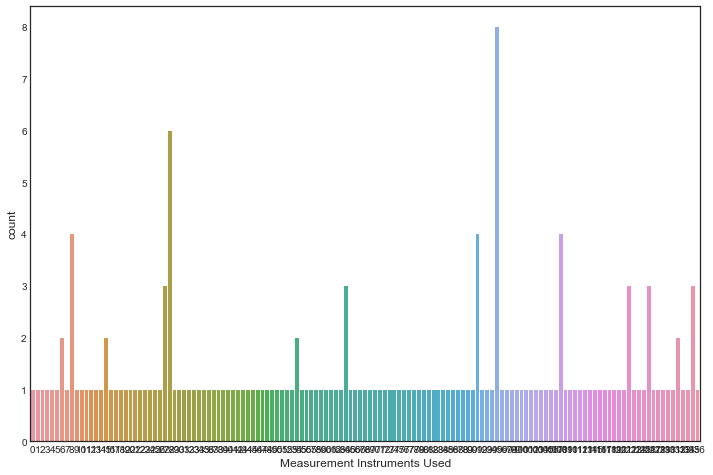

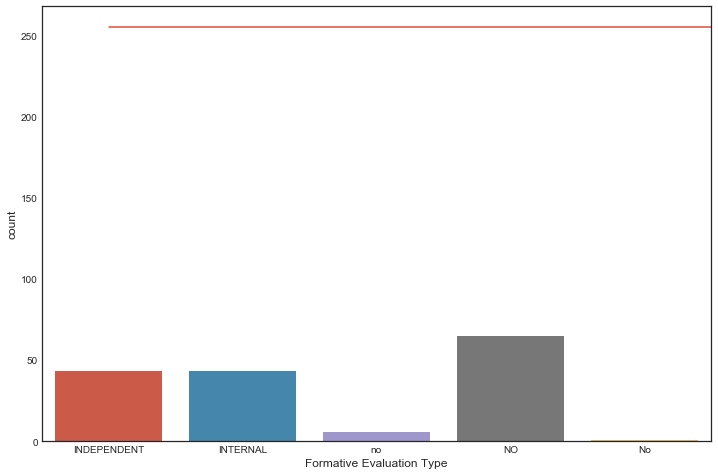

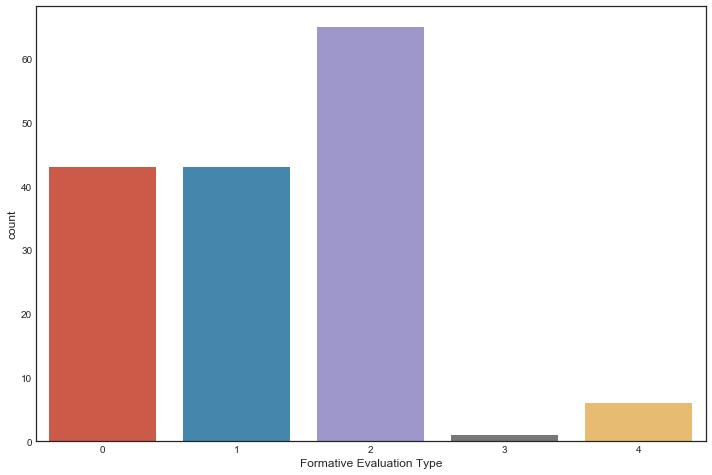

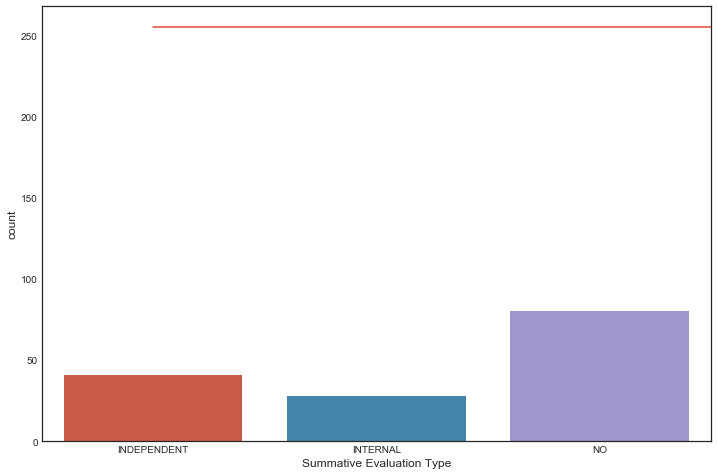

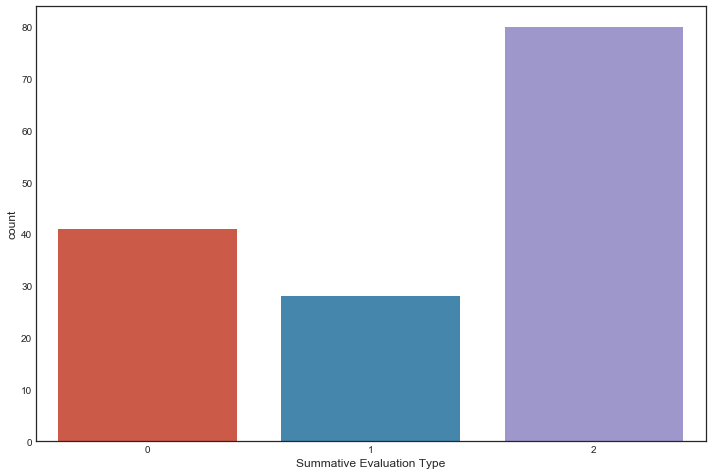

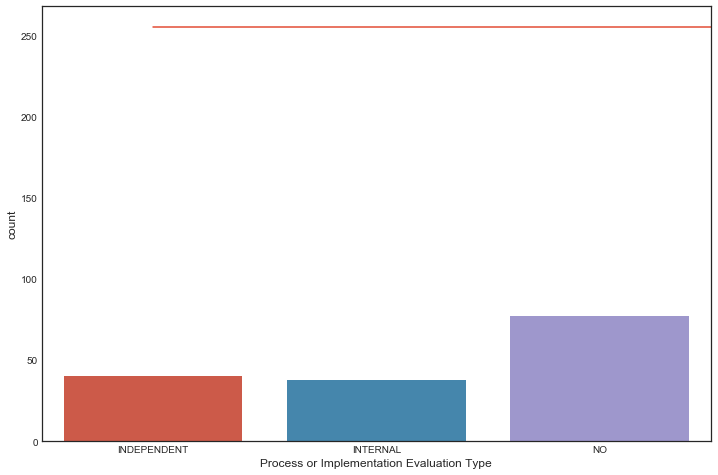

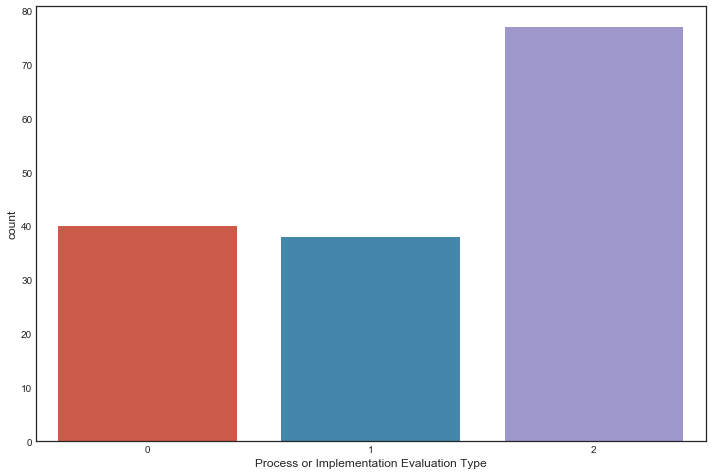

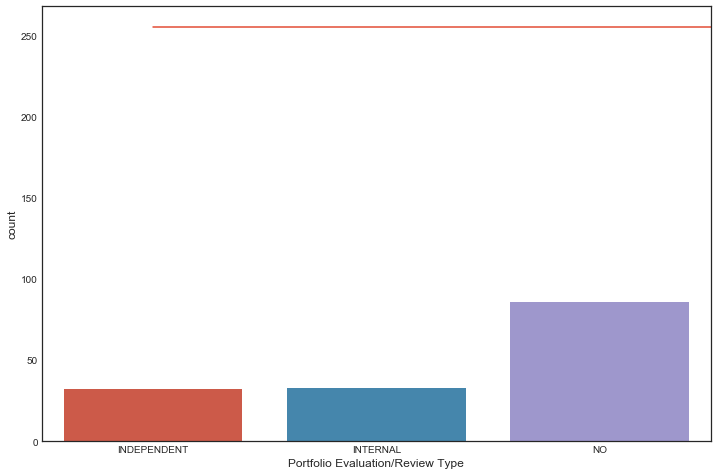

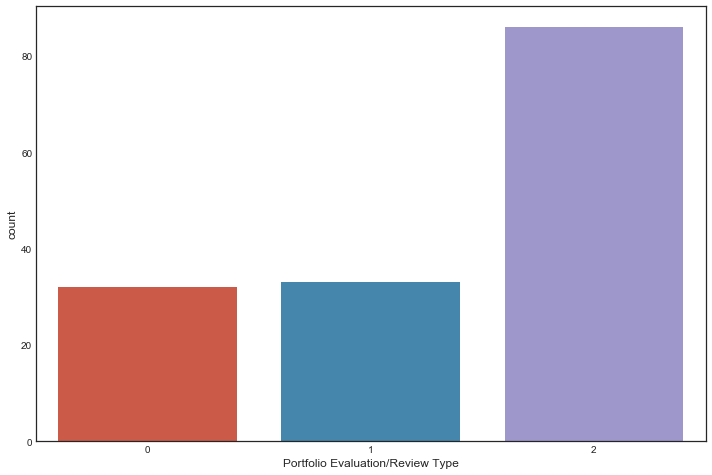

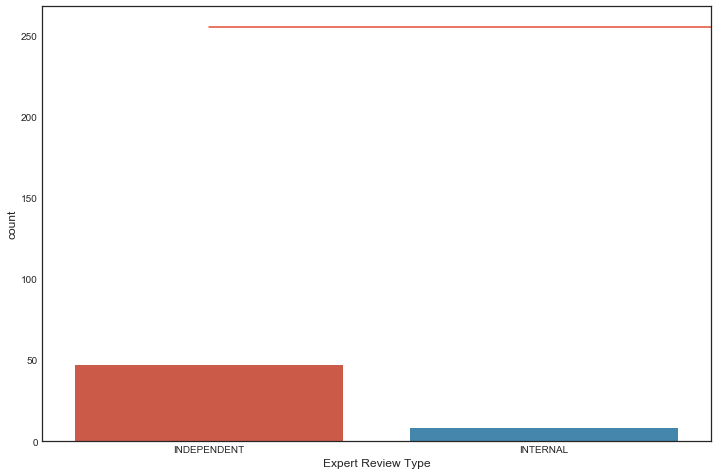

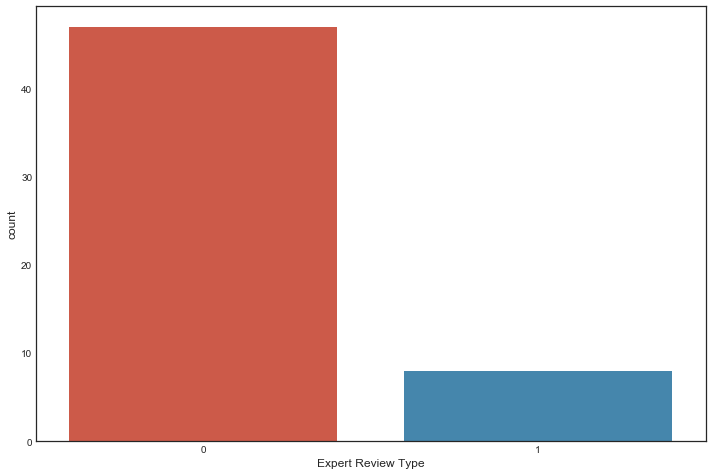

Plotting histograms ALSO separately for numerical features like Year/ Joint Funding


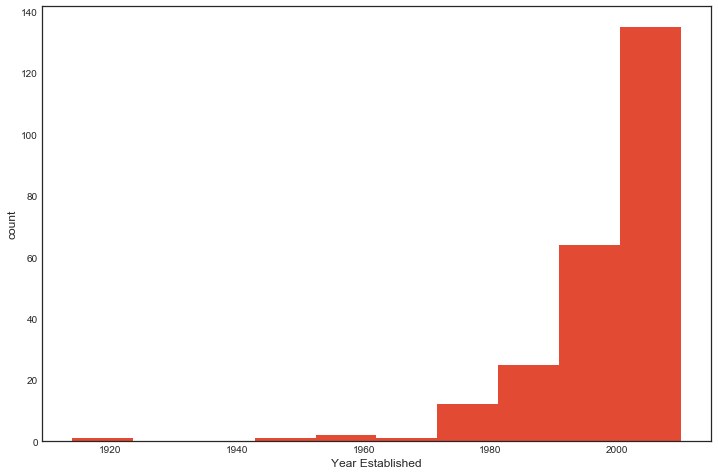

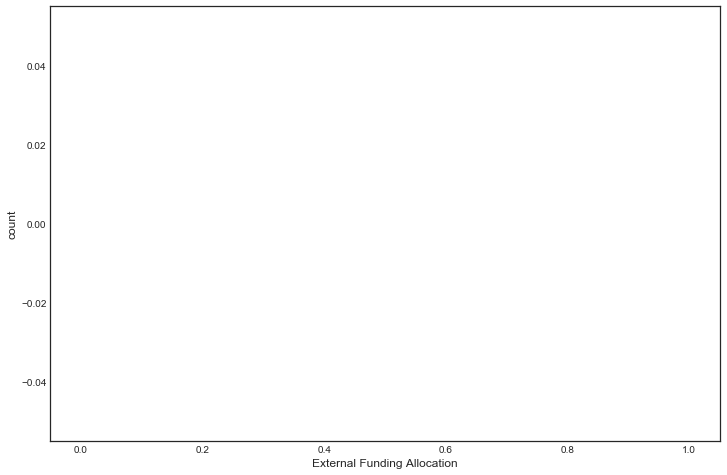

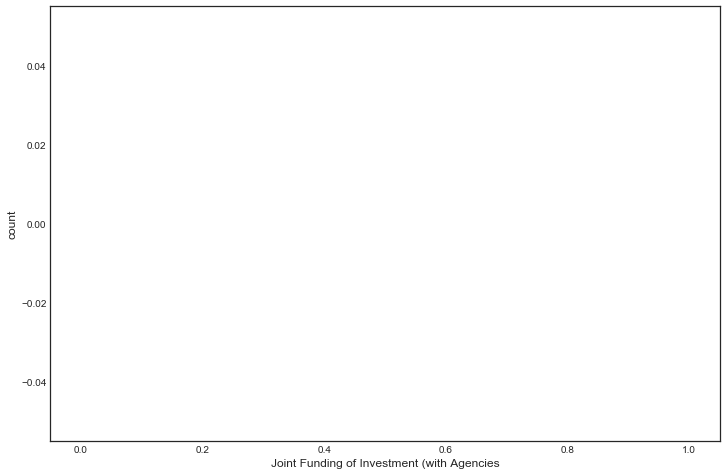

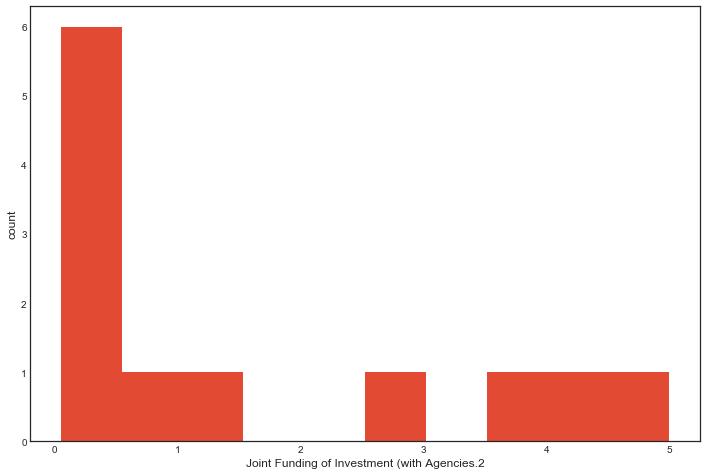

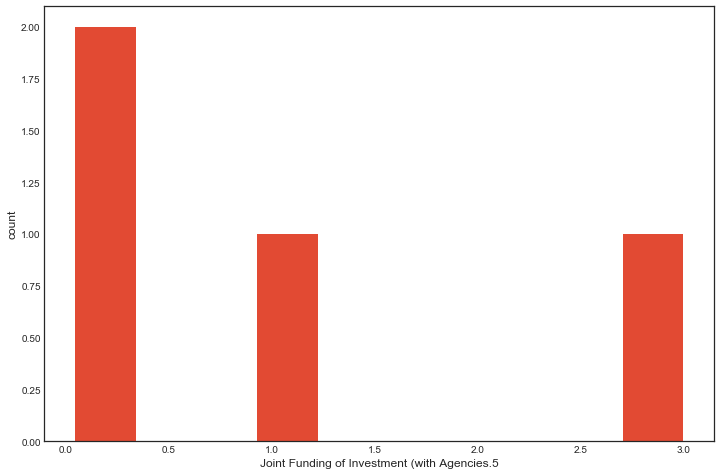

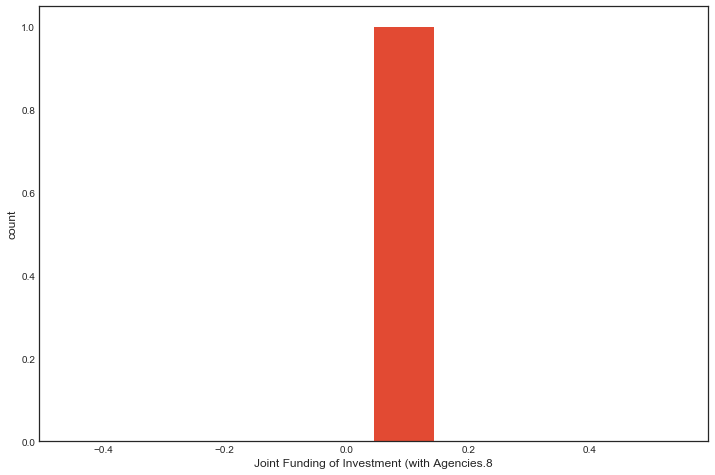

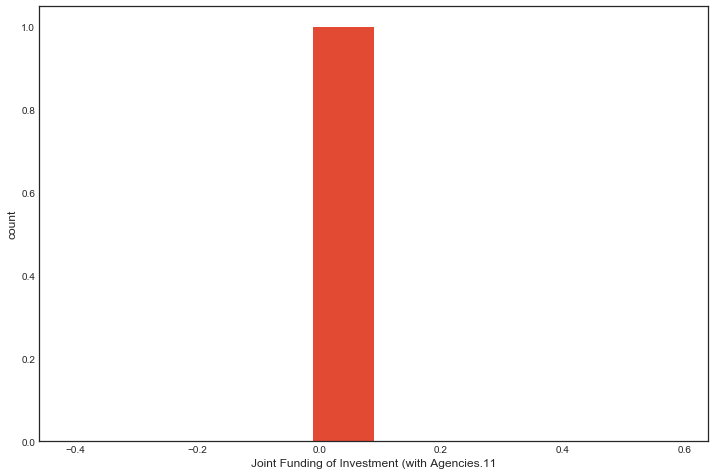

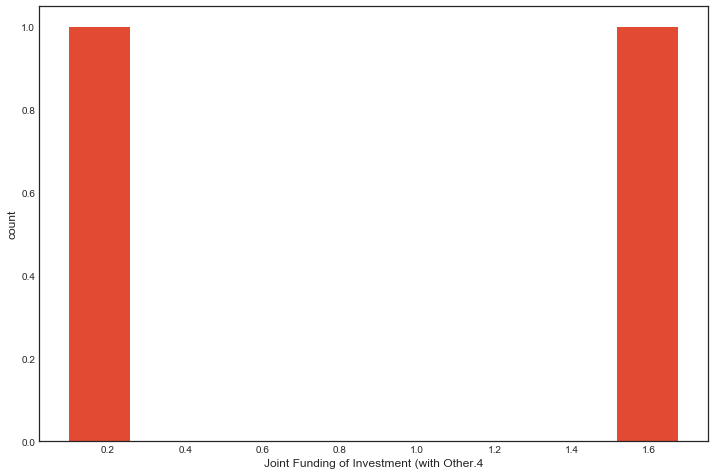

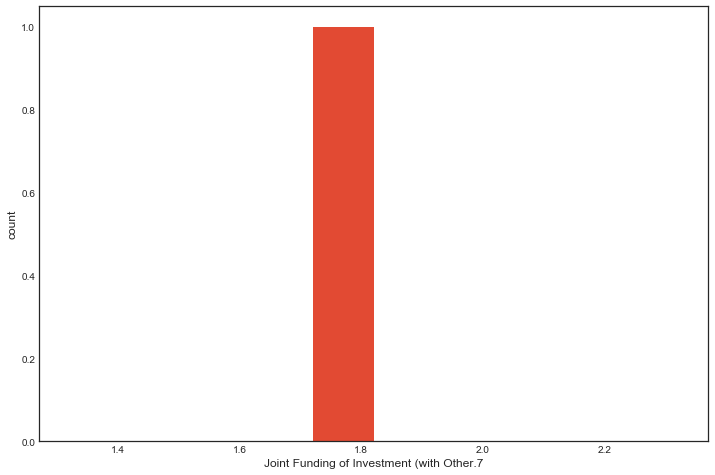

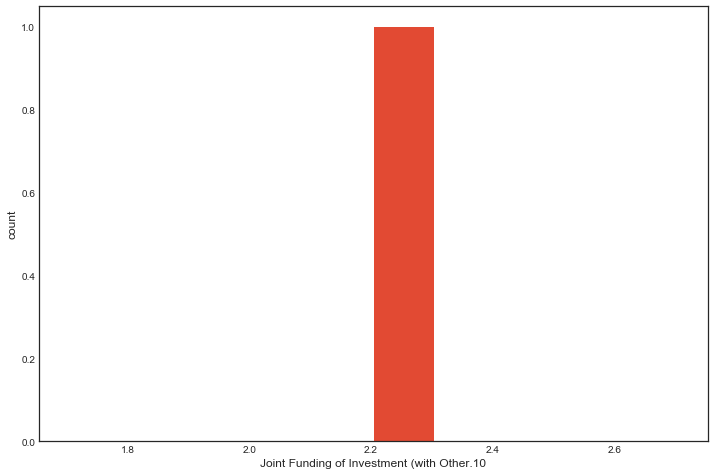

In [49]:
univariate_distribution(data) #Identical features (columns with same name combined for uni dist)

In [234]:
funding_variables=pd.DataFrame(data[['Funding FY2008','Funding FY2009','Funding FY2010']])
#funding_variables[funding_variables['Funding FY2008'].isnull().sum()]
data=data.drop(labels=['Funding FY2008','Funding FY2009','Funding FY2010'], axis=1 )

writer = pd.ExcelWriter('output.xlsx') #Applying shortcut to change same column names
data.to_excel(writer,'Sheet1')
writer.save()
data=pd.read_excel('output.xlsx')
Y=pd.DataFrame(funding_variables)



In [235]:
m=Y.iloc[:,0].isnull()
n=Y.iloc[:,1].isnull()
Z=Y[np.logical_or(m,n)]
Y.loc[n,'Funding FY2009']=Y.loc[n,'Funding FY2010']
Y.loc[Y.iloc[:,0].isnull(),'Funding FY2008']

PRG_0056    NaN
PRG_0060    NaN
PRG_0061    NaN
PRG_0066    NaN
PRG_0079    NaN
PRG_0080    NaN
PRG_0083    NaN
PRG_0086    NaN
PRG_0092    NaN
PRG_0098    NaN
PRG_0099    NaN
PRG_0101    NaN
PRG_0105    NaN
PRG_0120    NaN
PRG_0142    NaN
PRG_0153    NaN
PRG_0154    NaN
PRG_0161    NaN
PRG_0184    NaN
PRG_0287    NaN
PRG_0313    NaN
PRG_0326    NaN
Name: Funding FY2008, dtype: object

In [286]:
def targetvariable(inputfile):  #Data code is not added where I imputed the values using prediction and saved the files for use
    Y=pd.read_excel(inputfile)
    #print(Y[55:60])
    T=pd.DataFrame()
    T=Y['Funding FY2009']-Y['Funding FY2008']
    T['Target']=T.map(lambda q:1 if q>0 else 0)
    target=pd.DataFrame(T['Target'])
    return target


In [287]:
#TestCase4
def test_targetvariable():
    target=targetvariable('funding2.xlsx')
    assert target.shape==(252,1)
    val=np.unique(target.values)
    assert len(val)==2
    try:
        assert val[0]==0 and val[1]==1
    except:
        assert val[0]==1 and val[1]==0

In [465]:
target=targetvariable('funding2.xlsx') # Use this one as after iterations it is found that which model predicted better values

In [461]:
data=pd.read_excel('output.xlsx') 

# this data should be used for test cases below- as the unique column names have now been set

In [346]:
def Mutual_info(X,y,NaN): #NaN=choose-'yes', 'no' or 'random fill'
    if NaN=='yes':
        print('Yes with NaNs')
        encode_exclude_nans(X)
    elif NaN=='random fill':
        print('Yeah with Random fill of NaNs..good choice')
        print('Please wait... Filling with Random generator so as to get accurate Mutual info score')
        encode_exclude_nans(X)
        fillnans_unique(X)
    elif NaN=='no':
        print('With NaNs of a particular column label encoded as single category ')
        encode_include_nans(X) 
    NF_variable=[]
    mi=[]
    for i in X: 
        x=X[i].ravel()    
        score=metrics.mutual_info_score(x,y)
        #print(type(score),score)
        #break
        mi.append(score)
        NF_variable.append(i)    
    Mutual_info=pd.DataFrame({'Non Funding Variables':NF_variable,'MI Score':mi})
    return Mutual_info,X

 
def encode_include_nans(data):
    for i in data:
        #t=X.loc[n_null,i].astype('category')
        #X.loc[n_null,i]=t.cat.codes
        #t=X[i].astype('category')
        #X[i]=t.cat.codes        
        try:
            data[i]=label.fit_transform(data[i])
        except:
            data[i]=label.fit_transform(data[i].astype('str'))
    return data
    
def encode_exclude_nans(data):
    for i in data:    
        n_null=data.loc[:,i].notnull()
        try:
            data.loc[n_null,i]=label.fit_transform(data.loc[n_null,i])
        except:
            data.loc[n_null,i]=label.fit_transform(data.loc[n_null,i].astype('str'))
    
    return data

def fillnans_unique(data):
    #a=np.arange(255,1000)
    for l,i in enumerate(data):
        data.loc[data[i].isna(),i]=data.loc[data[i].isna(),i].apply(lambda z: int(rnd.random() * 1000))
    return data
        #for k,j in enumerate(data[i].isna()):
         #   if j==True:
          #      data[i][k]=rnd.choice(a)


In [462]:
#TestCase5
def test_encode_include_nans():
    S=data.shape                        # same way for fillnans_unique but I don't think its required to test if every
    Data=encode_include_nans(data)      # every nan is filled with unique as the code itself used random functioin so I trust it.
    assert Data.isnull().sum().sum()==0   # anyways code is written below
    assert Data.shape==S

In [370]:
#TestCase6
def test_encode_exclude_nans():
    S=data.shape 
    data1=data                       # running previous test will change data values so load again to use this one..and so on
    Data=encode_include_nans(data)
    assert Data.isnull().sum().sum()==data1.isnull().sum().sum()
    assert Data.shape==S

In [459]:
#TestCase7
def test_fillnans_unique():
    S=data.shape
    Tot=data.isnull().sum().sum()
    N=np.where(data.isnull())
    Data=fillnans_unique(data)
    m=N[0]
    n=N[1]
    i=0
    val=[]
    while i< Tot:
        val.append(Data.iloc[m[i],n[i]])
        i=i+1
    Val=np.array(val)
    assert len(np.unique(Val))>900  # as we have used range of 1000 so at most uniques values can be max 1000
    assert len(val)==Tot
    assert Data.isnull().values.sum()==0
    assert Data.shape==S

In [ ]:
#TestCase8
def test_Mutual_info():   #isinstance Dataframe can also be included in the test
    Mutualinfo=Mutual_info(X,y,NaN)      #upper bound can be defined by min of entropy of two variables min(H(X),H(Y))
    assert Mutualinfo['MI Score'].values.any()>0   # and sklearns MI uses natural log to calculate so 1 bit=0.693 
                                                    #So now I can't do that much calculation in so less time..
                                                # and neither it is necessary as we just have to check that is should be non neg.
                                            # or another option to check Normalized MI that lies b/w [0-1]

In [471]:
Mutualinfo['MI Score'].values.any()>0

True

In [466]:
X=pd.read_excel('output.xlsx')
Target=np.array(target).ravel()
Mutualinfo,X=Mutual_info(X,Target,NaN='random fill')

Yeah with Random fill of NaNs..good choice
Please wait... Filling with Random generator so as to get accurate Mutual info score


In [11]:
#FEATURE SELECTION
def feature_selector(X,y,Method,n): #if Method="MI_Chi" or 'MI_JMIM" or "Combine"
    if Method=='MI_Chi':
        print('Selection using Chi Test ')
        Mutualinfo,X=Mutual_info(X,y,NaN='random fill')
        Predictors=fselect_Chi(X,y,Mutualinfo)

    elif Method=='MI_JMIM':
        print('Using MI-JMIM')
        Mutualinfo,X=Mutual_info(X,y,NaN='random fill')
        Predictors=fselect_MI(X,y,n)
    
    elif Method=='Combine':
        print('Good Choice= First selecting significance from Chi Square Test then using JointMI_Maxim')
        Mutualinfo,X=Mutual_info(X,y,NaN='random fill')
        Predictors=fselect_Chi(X,y,Mutualinfo)
        X=X[Predictors]
        #X=fillnans_unique(X)
        Predictors=fselect_MI(X,y,n)
    return Predictors

def fselect_Chi(X,y,Mutualinfo): # use X with Nans
    N=len(X)
    S=2*N
    predictors=[]
    levels=describe_more(X)[3]
    stop=len(Mutualinfo)
    i=0
    while i<stop:
        v=Mutualinfo.loc[i,'MI Score']; m=Mutualinfo.loc[i,'Non Funding Variables']; l=levels[i]
        if (l-1)<101:
            g=int(chivalue.loc[chivalue['df']==l-1,'value'])
            chi2=g
            if v > (chi2)/S:
                predictors.append(m)
        else:
            chi2=l+30
            if v > (chi2)/S:
                predictors.append(m)
        i=i+1
    return predictors

def fselect_MI(X,y,n): #Use X without Nans
    fselect =mifs.MutualInformationFeatureSelector(method='JMIM',verbose=2,n_features=n)
    fselect.fit(X,y)
    predictors=list(X.columns.values[fselect.support_])
    #predictors_rank=fselect.ranking_
    #fx=np.array(X)
    #X_filtered = fselect.transform(fx)
    return predictors


In [ ]:
#Nothing concrete to test in above functions as all are just returning the selected predictors so it would be farce to
#check if returned predictors are there in column names list or not.   Still..-

In [ ]:
#test_common():
#assert len(predictors)>0    to check if atleast 1 one predictor is selected
 

In [12]:
chivalue=pd.read_excel('chivalue0.05.xlsx')

In [13]:
X=pd.read_excel('output.xlsx')   #n= integer for no of features req or 'auto'
Target=np.array(target1).ravel()
Predictors=feature_selector(X,Target,'Combine',n='auto')

Good Choice= First selecting significance from Chi Square Test then using JointMI_Maxim
Yeah with Random fill of NaNs..good choice
Please wait... Filling with Random generator so as to get accurate Mutual info score
The values of X seem to be discrete. MI_FS will treat themas continuous.
Auto selected feature #1 : 155, JMIM : 0.03464492755578519
Auto selected feature #2 : 227, JMIM : 0.13394089720159696
Auto selected feature #3 : 36, JMIM : 0.0937736445613373
Auto selected feature #4 : 136, JMIM : 0.08837118163397051
Auto selected feature #5 : 121, JMIM : 0.07086600509042462
Auto selected feature #6 : 32, JMIM : 0.06361626454367242
Auto selected feature #7 : 211, JMIM : 0.05793786191883221
Auto selected feature #8 : 112, JMIM : 0.05290299718183045
Auto selected feature #9 : 6, JMIM : 0.05095195899821814
Auto selected feature #10 : 75, JMIM : 0.04988986868153056
Auto selected feature #11 : 30, JMIM : 0.04724294437541943
Auto selected feature #12 : 233, JMIM : 0.046240099893933184
Auto s

In [24]:
X1=pd.read_excel('output.xlsx')
Target=np.array(target1).ravel()
Predictors1=feature_selector(X1,Target,'MI_Chi','auto')

Selection using Chi Test 
Yeah with Random fill of NaNs..good choice
Please wait... Filling with Random generator so as to get accurate Mutual info score


In [31]:
X2=pd.read_excel('output.xlsx')
Target=np.array(target1).ravel()
Predictors2=feature_selector(X2,Target,'MI_JMIM','auto')

Using MI-JMIM
Yeah with Random fill of NaNs..good choice
Please wait... Filling with Random generator so as to get accurate Mutual info score
The values of X seem to be discrete. MI_FS will treat themas continuous.
Auto selected feature #1 : 177, JMIM : 0.024703054814981584
Auto selected feature #2 : 201, JMIM : 0.1141356747785518
Auto selected feature #3 : 160, JMIM : 0.08063671995978172
Auto selected feature #4 : 246, JMIM : 0.07350125169901389
Auto selected feature #5 : 7, JMIM : 0.062003144548199884
Auto selected feature #6 : 147, JMIM : 0.059702424099167484
Auto selected feature #7 : 52, JMIM : 0.05930836194909306
Auto selected feature #8 : 211, JMIM : 0.05825950492165477
Auto selected feature #9 : 30, JMIM : 0.05556296114308612
Auto selected feature #10 : 207, JMIM : 0.05440233194913846
Auto selected feature #11 : 145, JMIM : 0.05191320524091614
Auto selected feature #12 : 200, JMIM : 0.050828749337887835
Auto selected feature #13 : 140, JMIM : 0.04937374021895735
Auto selected f

In [14]:
#One hot encoding with threshold of 2.5% of total sample values
def get_columns(data,predictors): #data with Nans-To get columns requiring one hot encd
    col_onehot=[]
    data=data[predictors]
    threshold=int(0.025*len(data))
    for x in data:
        yum=data[x]
        if yum.dtypes!=np.number:
            count=yum.value_counts()
            j=0
            for i in count:
                if int(i)>threshold:
                    j=j+1
                    if j>1:
                        col_onehot.append(x)
                        break
    return col_onehot

def split_columns(data,X,predictors): # One hot coding whith threshold of 2.5% of N
    col_onehot=get_columns(data,predictors)
    threshold = int(0.025*len(data))
    X=X[predictors]
    for i in col_onehot:    
        counts = X[i].value_counts()
        repl = counts[counts <= threshold].index        
        X=pd.concat([pd.get_dummies(X[i].replace(repl,'uncommon'),prefix=i),X.drop(i,axis=1)],axis=1)            
    return X


In [ ]:
#get_columns- just return the column names that needs to be one hot encoded, so it's same case as in predictors still...
#TestCase9,10
def test_get_columns():
    col_onehot=get_columns(data,predictors)
    assert isinstance(col_onehot,list)

def test_split_columns():           #dummies is not user built function so no need to test if no. of columns split for each
    X=split_columns(data,X,predictors)   # category == no. of levels for that category.
    
    assert X.shape[1]> data[predictors].shape[1]  #assuming col_onehot is non empty else >= instead of >